In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_infertility = pd.read_csv("PCOS_infertility.csv")
df_survey = pd.read_csv("pcos_survey_clean.csv")
df_wo_infertility = pd.read_excel("PCOS_data_without_infertility.xlsx")

In [4]:
df_wo_infertility.shape

(20, 4)

In [5]:
df_wo_infertility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Instructions to be followed :  12 non-null     float64
 1   Unnamed: 1                     12 non-null     object 
 2   Unnamed: 2                     0 non-null      float64
 3   Unnamed: 3                     8 non-null      object 
dtypes: float64(2), object(2)
memory usage: 772.0+ bytes


In [6]:
df_wo_infertility.head

<bound method NDFrame.head of     Instructions to be followed :  \
0                             NaN   
1                             1.0   
2                             2.0   
3                             3.0   
4                             4.0   
5                             5.0   
6                             NaN   
7                             NaN   
8                             NaN   
9                             NaN   
10                            NaN   
11                            NaN   
12                            NaN   
13                            6.0   
14                            7.0   
15                            8.0   
16                            9.0   
17                           10.0   
18                           11.0   
19                           12.0   

                                           Unnamed: 1  Unnamed: 2 Unnamed: 3  
0                                                 NaN         NaN        NaN  
1    Kindly ensure that the datas 

In [7]:
df_wo_infertility.isnull().sum()

Instructions to be followed :     8
Unnamed: 1                        8
Unnamed: 2                       20
Unnamed: 3                       12
dtype: int64

In [8]:
df_survey.shape

(465, 16)

In [9]:
df_survey.head

<bound method NDFrame.head of      Age (in Years)  Weight (in Kg)  Height (in Cm / Feet)  \
0                21            47.0                  168.0   
1                21            45.0                  156.0   
2                17            37.0                  162.0   
3                28            54.0                  160.0   
4                45            40.0                  150.0   
..              ...             ...                    ...   
460              20            80.0                  160.0   
461              26            62.0                  150.0   
462              18            63.0                  154.0   
463              18            47.0                  163.0   
464              17            45.0                  160.0   

     Can you tell us your blood group ?  \
0                                    13   
1                                    11   
2                                    15   
3                                    15   
4         

blood type codes:
A+ = 11  
 A- = 12  
 B+ = 13  
 B- = 14  
 O+ =15   
 O- = 16  
 AB+ =17  
 AB- = 18

In [11]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 16 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Age (in Years)                                                                     465 non-null    int64  
 1   Weight (in Kg)                                                                     465 non-null    float64
 2   Height (in Cm / Feet)                                                              465 non-null    float64
 3   Can you tell us your blood group ?                                                 465 non-null    int64  
 4   After how many months do you get your periods?
(select 1- if every month/regular)  465 non-null    int64  
 5   Have you gained weight recently?                                                   465 non-null    int64  

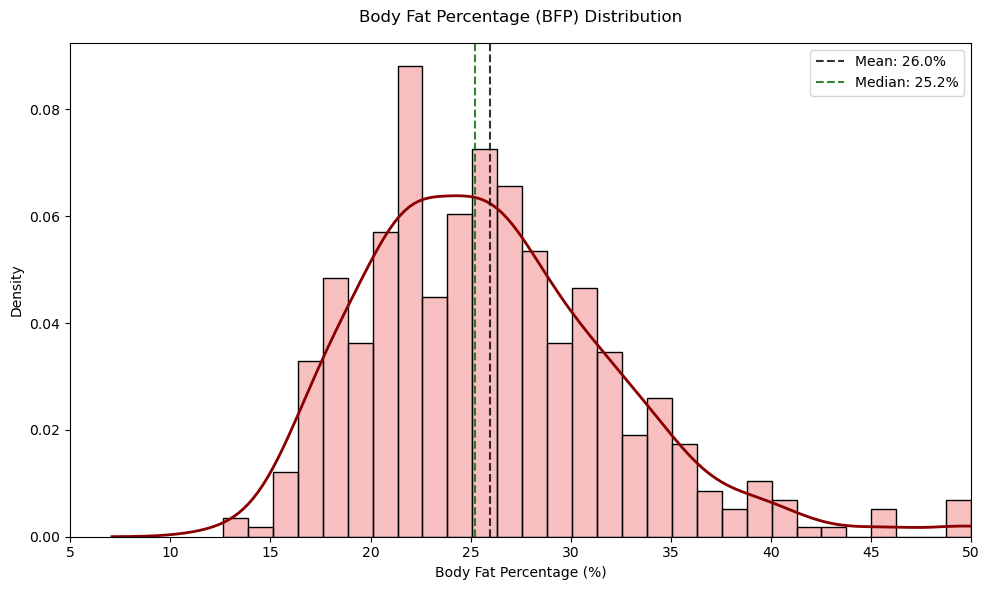


BFP Summary Statistics:
count    465.000000
mean      25.964497
std        6.318620
min       12.628153
25%       21.551358
50%       25.217595
75%       29.598095
max       50.000000
Name: BFP, dtype: float64


In [12]:
# Recalculate height in meters
df_survey['Height_m'] = df_survey['Height (in Cm / Feet)'] / 100

# Calculate BMI
df_survey['BMI'] = df_survey['Weight (in Kg)'] / (df_survey['Height_m'] ** 2)

# Calculate BFP for women using the correct Deurenberg formula
df_survey['BFP'] = (1.20 * df_survey['BMI']) + (0.23 * df_survey['Age (in Years)']) - 5.4 - 2.8

# Add validation to ensure BFP is within reasonable ranges
df_survey['BFP'] = df_survey['BFP'].clip(lower=5, upper=50)

# Create the visualization
plt.figure(figsize=(10, 6))

# Create main distribution plot
sns.histplot(data=df_survey, x='BFP', 
            bins=30,
            stat='density',
            kde=True,
            color='lightcoral',
            alpha=0.5)

# Add KDE plot
sns.kdeplot(data=df_survey['BFP'],
            color='darkred',
            linewidth=2)

# Customize the plot
plt.title('Body Fat Percentage (BFP) Distribution', pad=15)
plt.xlabel('Body Fat Percentage (%)')
plt.ylabel('Density')
plt.xlim(5, 50)

# Add mean and median lines
mean_bfp = df_survey['BFP'].mean()
median_bfp = df_survey['BFP'].median()
plt.axvline(mean_bfp, color='black', linestyle='--', alpha=0.8, label=f'Mean: {mean_bfp:.1f}%')
plt.axvline(median_bfp, color='darkgreen', linestyle='--', alpha=0.8, label=f'Median: {median_bfp:.1f}%')

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

plt.show()

# Print summary statistics
print("\nBFP Summary Statistics:")
print(df_survey['BFP'].describe())

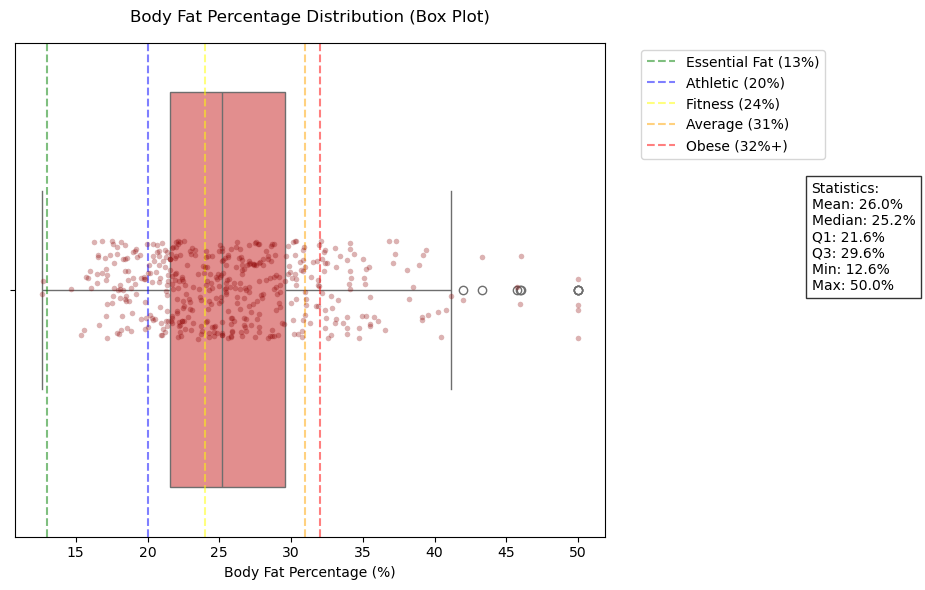


Outlier Analysis:
Number of outliers: 9
Outlier values: [41.96925925925927, 43.332844016035324, 45.71442330558858, 45.96516491541239, 46.00351657268044, 50.0, 50.0, 50.0, 50.0]


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.boxplot(x=df_survey['BFP'], color='lightcoral')

sns.stripplot(x=df_survey['BFP'], color='darkred', alpha=0.3, size=4)

plt.title('Body Fat Percentage Distribution (Box Plot)', pad=15)
plt.xlabel('Body Fat Percentage (%)')

plt.axvline(x=13, color='green', linestyle='--', alpha=0.5, label='Essential Fat (13%)')
plt.axvline(x=20, color='blue', linestyle='--', alpha=0.5, label='Athletic (20%)')
plt.axvline(x=24, color='yellow', linestyle='--', alpha=0.5, label='Fitness (24%)')
plt.axvline(x=31, color='orange', linestyle='--', alpha=0.5, label='Average (31%)')
plt.axvline(x=32, color='red', linestyle='--', alpha=0.5, label='Obese (32%+)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

stats = df_survey['BFP'].describe()
plt.text(1.35, 0.5, 
         f"Statistics:\nMean: {stats['mean']:.1f}%\nMedian: {stats['50%']:.1f}%\n" + 
         f"Q1: {stats['25%']:.1f}%\nQ3: {stats['75%']:.1f}%\n" +
         f"Min: {stats['min']:.1f}%\nMax: {stats['max']:.1f}%",
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Q1 = stats['25%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_survey[df_survey['BFP'].between(lower_bound, upper_bound) == False]['BFP']

print("\nOutlier Analysis:")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier values: {sorted(outliers.values) if len(outliers) > 0 else 'None'}")

In [14]:
df_survey.loc[:, 'BFP_log'] = np.log(df_survey['BFP'] + 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


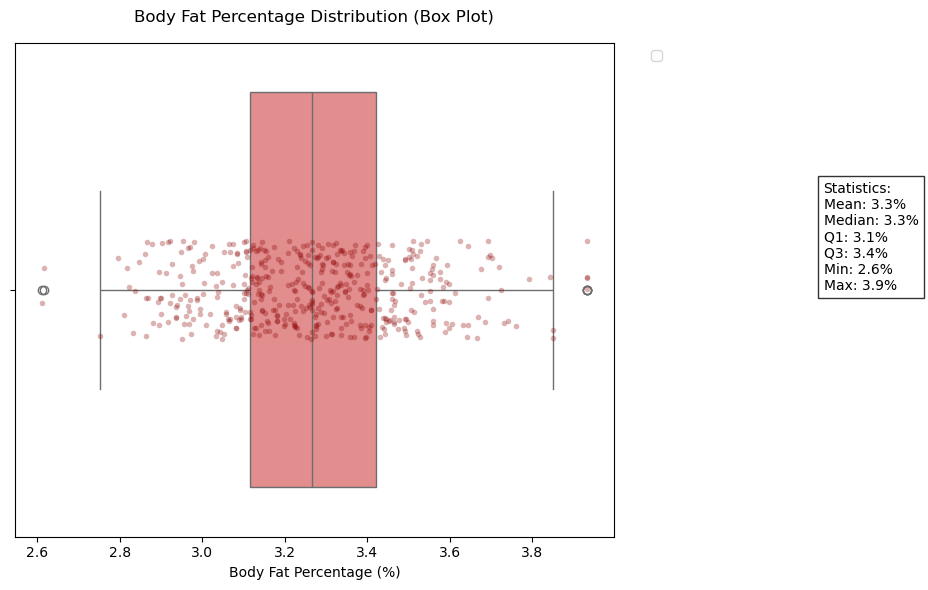


Outlier Analysis:
Number of outliers: 6
Outlier values: [2.612137706121448, 2.617071726958651, 3.9318256327243257, 3.9318256327243257, 3.9318256327243257, 3.9318256327243257]


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.boxplot(x=df_survey['BFP_log'], color='lightcoral')

sns.stripplot(x=df_survey['BFP_log'], color='darkred', alpha=0.3, size=4)

plt.title('Body Fat Percentage Distribution (Box Plot)', pad=15)
plt.xlabel('Body Fat Percentage (%)')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

stats = df_survey['BFP_log'].describe()
plt.text(1.35, 0.5, 
         f"Statistics:\nMean: {stats['mean']:.1f}%\nMedian: {stats['50%']:.1f}%\n" + 
         f"Q1: {stats['25%']:.1f}%\nQ3: {stats['75%']:.1f}%\n" +
         f"Min: {stats['min']:.1f}%\nMax: {stats['max']:.1f}%",
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Q1 = stats['25%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_survey[df_survey['BFP_log'].between(lower_bound, upper_bound) == False]['BFP_log']

print("\nOutlier Analysis:")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier values: {sorted(outliers.values) if len(outliers) > 0 else 'None'}")

BFP Summary Statistics (Raw):
count    465.000000
mean      25.964497
std        6.318620
min       12.628153
25%       21.551358
50%       25.217595
75%       29.598095
max       50.000000
Name: BFP, dtype: float64

BFP_log Summary Statistics:
count    465.000000
mean       3.228636
std        0.235969
min        2.535929
25%        3.070439
50%        3.227542
75%        3.387710
max        3.912023
Name: BFP_log, dtype: float64
BFP_log Range: 2.5359286644317582 3.912023005428146


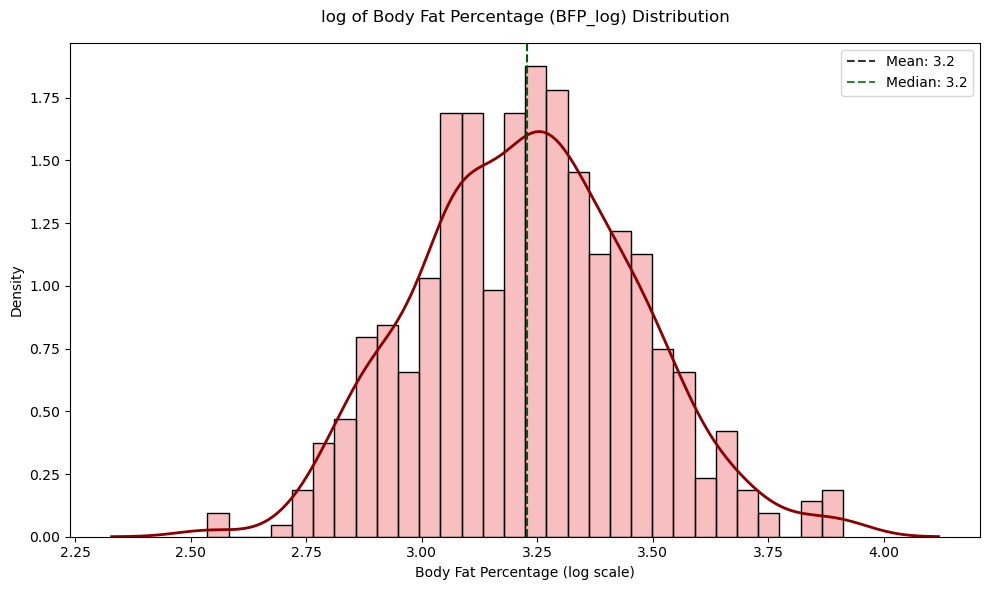

In [16]:
# Print summary statistics and check the range
print("BFP Summary Statistics (Raw):")
print(df_survey['BFP'].describe())

# Log transform and check the result
df_survey['BFP_log'] = np.log(df_survey['BFP'])
print("\nBFP_log Summary Statistics:")
print(df_survey['BFP_log'].describe())

# Check the min and max of BFP_log
print("BFP_log Range:", df_survey['BFP_log'].min(), df_survey['BFP_log'].max())

# Create the visualization
plt.figure(figsize=(10, 6))

# Create main distribution plot for BFP_log
sns.histplot(data=df_survey, x='BFP_log', 
            bins=30,
            stat='density',
            kde=True,
            color='lightcoral',
            alpha=0.5)

# Add KDE plot
sns.kdeplot(data=df_survey['BFP_log'],
            color='darkred',
            linewidth=2)

# Customize the plot
plt.title('log of Body Fat Percentage (BFP_log) Distribution', pad=15)
plt.xlabel('Body Fat Percentage (log scale)')
plt.ylabel('Density')

# Add mean and median lines
mean_bfp_log = df_survey['BFP_log'].mean()
median_bfp_log = df_survey['BFP_log'].median()
plt.axvline(mean_bfp_log, color='black', linestyle='--', alpha=0.8, label=f'Mean: {mean_bfp_log:.1f}')
plt.axvline(median_bfp_log, color='darkgreen', linestyle='--', alpha=0.8, label=f'Median: {median_bfp_log:.1f}')

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

plt.show()


In [17]:
df_survey.head()

,Age (in Years),Weight (in Kg),Height (in Cm / Feet),Can you tell us your blood group ?,After how many months do you get your periods?\n(select 1- if every month/regular),Have you gained weight recently?,Do you have excessive body/facial hair growth ?,Are you noticing skin darkening recently?,Do have hair loss/hair thinning/baldness ?,Do you have pimples/acne on your face/jawline ?,Do you eat fast food regularly ?,Do you exercise on a regular basis ?,Have you been diagnosed with PCOS/PCOD?,Do you experience mood swings ?,Are your periods regular ?,"How long does your period last ? (in Days)\nexample- 1,2,3,4.....",Height_m,BMI,BFP,BFP_log
0,21,47.0,168.0,13,1,0,0,0,0,0,0,0,0,1,1,6,1.68,16.652494,16.612993,2.810185
1,21,45.0,156.0,11,1,0,0,1,1,1,0,0,0,1,1,4,1.56,18.491124,18.819349,2.934886
2,17,37.0,162.0,15,1,0,0,0,0,1,1,0,0,1,1,6,1.62,14.098461,12.628153,2.535929
3,28,54.0,160.0,15,1,0,0,0,0,0,0,0,0,1,1,4,1.60,21.093750,23.552500,3.159232
4,45,40.0,150.0,13,2,0,0,0,1,0,0,0,1,1,0,7,1.50,17.777778,23.483333,3.156291


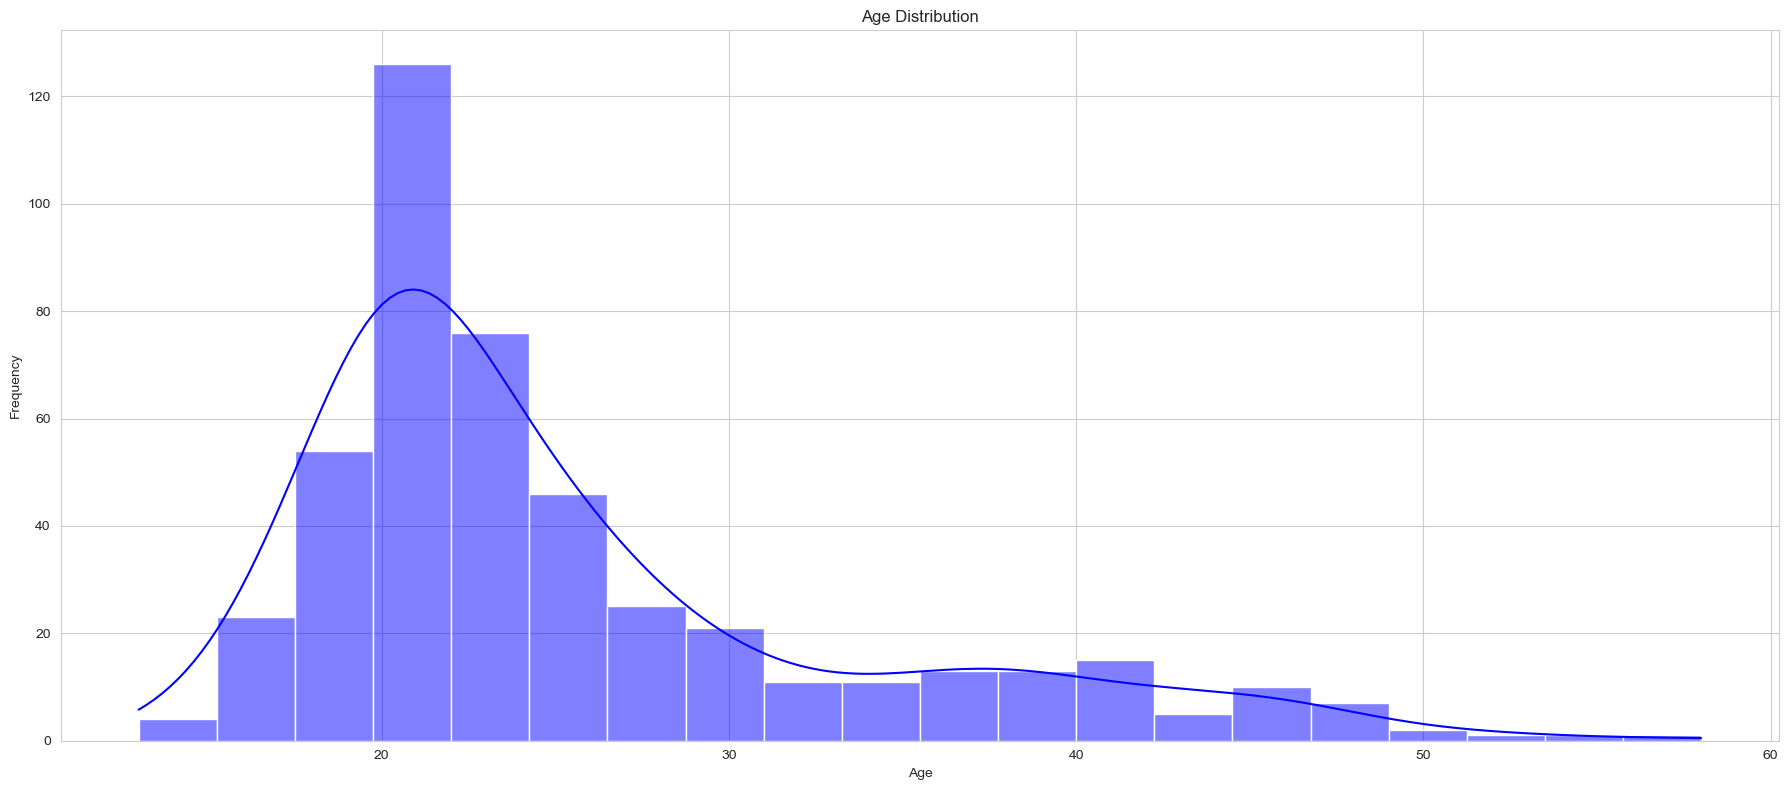

In [18]:
sns.set_style("whitegrid")

# Create subplots with a larger figure size
fig, ax = plt.subplots(figsize=(18, 8))  # Adjust the size as needed

# Plot Age distribution
sns.histplot(df_survey['Age (in Years)'], kde=True, bins=20, ax=ax, color='blue')
ax.set_title("Age Distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


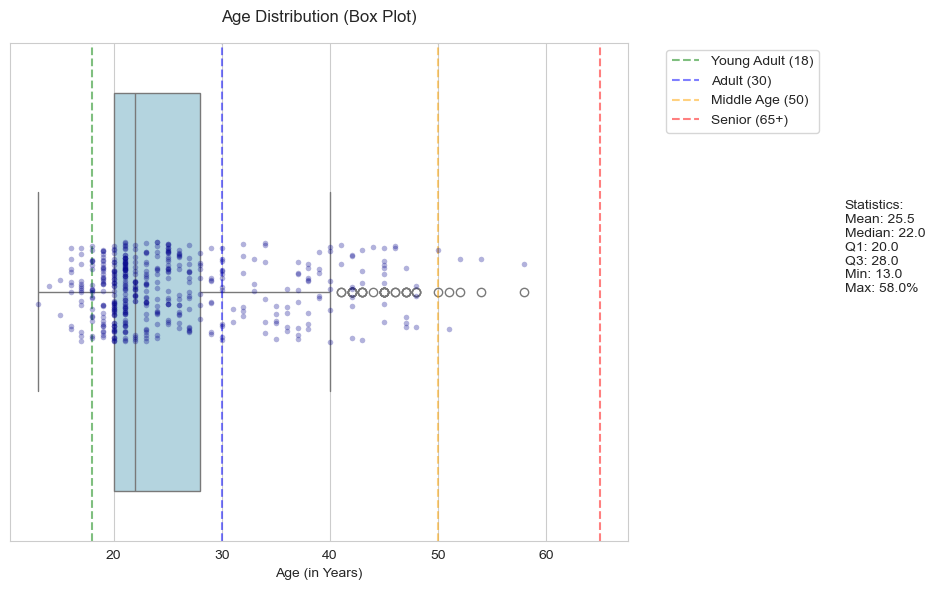


Outlier Analysis:
Number of outliers: 14
Outlier values: [46, 46, 47, 47, 47, 47, 48, 48, 48, 50, 51, 52, 54, 58]


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Boxplot for Age distribution
sns.boxplot(x=df_survey['Age (in Years)'], color='lightblue')

# Add stripplot for individual data points
sns.stripplot(x=df_survey['Age (in Years)'], color='darkblue', alpha=0.3, size=4)

# Set plot title and labels
plt.title('Age Distribution (Box Plot)', pad=15)
plt.xlabel('Age (in Years)')

# Optionally, add vertical lines for specific age ranges
# Example age thresholds (you can customize them)
plt.axvline(x=18, color='green', linestyle='--', alpha=0.5, label='Young Adult (18)')
plt.axvline(x=30, color='blue', linestyle='--', alpha=0.5, label='Adult (30)')
plt.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Middle Age (50)')
plt.axvline(x=65, color='red', linestyle='--', alpha=0.5, label='Senior (65+)')

# Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Statistics text box
stats = df_survey['Age (in Years)'].describe()
plt.text(1.35, 0.5, 
         f"Statistics:\nMean: {stats['mean']:.1f}\nMedian: {stats['50%']:.1f}\n" + 
         f"Q1: {stats['25%']:.1f}\nQ3: {stats['75%']:.1f}\n" +
         f"Min: {stats['min']:.1f}\nMax: {stats['max']:.1f}%",
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Outlier analysis
Q1 = stats['25%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = 45
outliers = df_survey[df_survey['Age (in Years)'].between(lower_bound, upper_bound) == False]['Age (in Years)']

print("\nOutlier Analysis:")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier values: {sorted(outliers.values) if len(outliers) > 0 else 'None'}")


In [20]:
df_survey.loc[:, 'Age_log'] = np.log(df_survey['Age (in Years)'] + 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


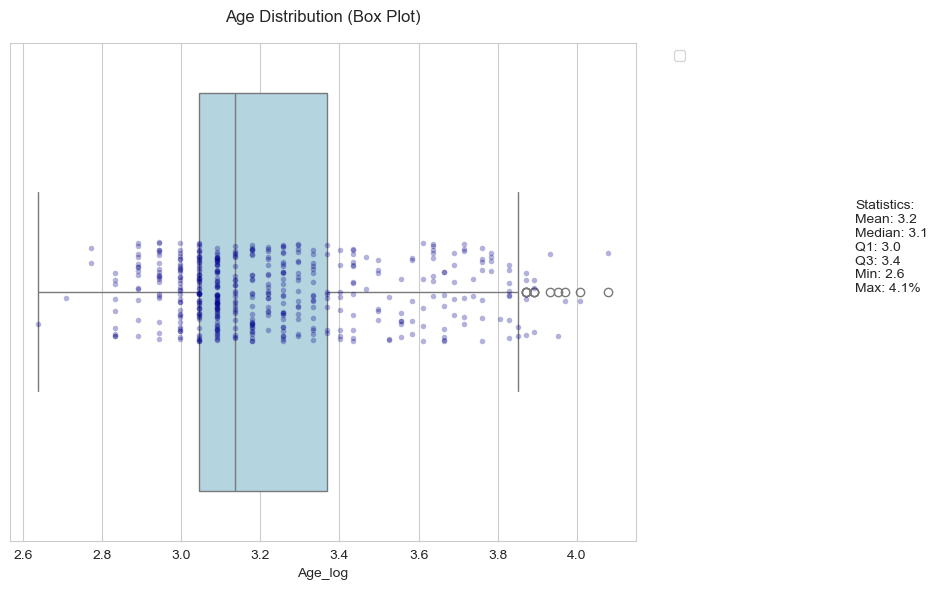


Outlier Analysis:
Number of outliers: 12
Outlier values: [3.871201010907891, 3.871201010907891, 3.871201010907891, 3.871201010907891, 3.8918202981106265, 3.8918202981106265, 3.8918202981106265, 3.9318256327243257, 3.9512437185814275, 3.970291913552122, 4.007333185232471, 4.07753744390572]


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Boxplot for Age distribution
sns.boxplot(x=df_survey['Age_log'], color='lightblue')

# Add stripplot for individual data points
sns.stripplot(x=df_survey['Age_log'], color='darkblue', alpha=0.3, size=4)

# Set plot title and labels
plt.title('Age Distribution (Box Plot)', pad=15)
plt.xlabel('Age_log')



# Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Statistics text box
stats = df_survey['Age_log'].describe()
plt.text(1.35, 0.5, 
         f"Statistics:\nMean: {stats['mean']:.1f}\nMedian: {stats['50%']:.1f}\n" + 
         f"Q1: {stats['25%']:.1f}\nQ3: {stats['75%']:.1f}\n" +
         f"Min: {stats['min']:.1f}\nMax: {stats['max']:.1f}%",
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Outlier analysis
Q1 = stats['25%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_survey[df_survey['Age_log'].between(lower_bound, upper_bound) == False]['Age_log']

print("\nOutlier Analysis:")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier values: {sorted(outliers.values) if len(outliers) > 0 else 'None'}")


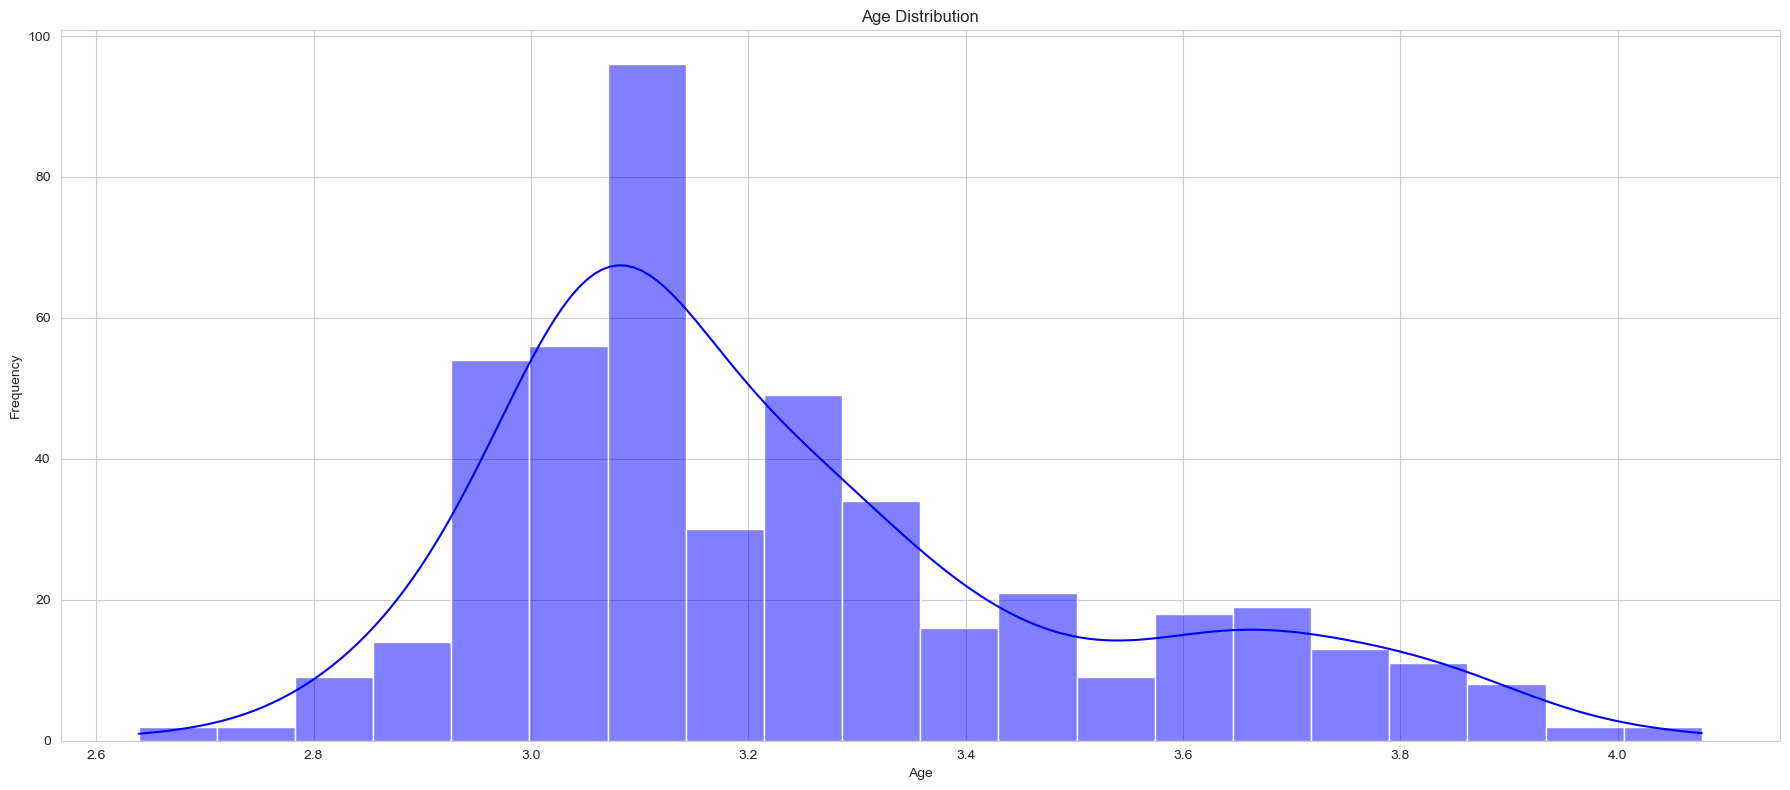

In [22]:
sns.set_style("whitegrid")

# Create subplots with a larger figure size
fig, ax = plt.subplots(figsize=(18, 8))  # Adjust the size as needed

# Plot Age distribution
sns.histplot(df_survey['Age_log'], kde=True, bins=20, ax=ax, color='blue')
ax.set_title("Age Distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [23]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 21 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Age (in Years)                                                                     465 non-null    int64  
 1   Weight (in Kg)                                                                     465 non-null    float64
 2   Height (in Cm / Feet)                                                              465 non-null    float64
 3   Can you tell us your blood group ?                                                 465 non-null    int64  
 4   After how many months do you get your periods?
(select 1- if every month/regular)  465 non-null    int64  
 5   Have you gained weight recently?                                                   465 non-null    int64  

In [57]:
# Dictionary to rename columns
rename_columns = {
    'Can you tell us your blood group ?': 'Blood_Group',
    'After how many months do you get your periods?\n(select 1- if every month/regular)': 'Periods_Frequency',
    'Have you gained weight recently?': 'Weight_Gain',
    'Do you have excessive body/facial hair growth ?': 'Excessive_Hair_Growth',
    'Are you noticing skin darkening recently?': 'Skin_Darkening',
    'Do have hair loss/hair thinning/baldness ?': 'Hair_Loss_Thinning',
    'Do you have pimples/acne on your face/jawline ?': 'Acne_Face_Jawline',
    'Do you eat fast food regularly ?': 'Fast_Food_regularly',
    'Do you exercise on a regular basis ?': 'Regular_Exercise',
    'Have you been diagnosed with PCOS/PCOD?': 'Diagnosed_PCOS_PCOD',
    'Do you experience mood swings ?': 'Mood_Swings',
    'Are your periods regular ?': 'Regular_Periods',
    'How long does your period last ? (in Days)\nexample- 1,2,3,4.....': 'Period_Duration_Days',
    'Height_m': 'Height_meters',
    'BMI': 'Body_Mass_Index',
    'BFP': 'Body_Fat_Percentage',
    'BFP_log': 'BFP_log',
    'Age_log': 'Age_log'
}


# Rename the columns using the dictionary
df_survey.rename(columns=rename_columns, inplace=True)

# Verify the changes
print(df_survey.columns)


Index(['Age (in Years)', 'Weight (in Kg)', 'Height (in Cm / Feet)',
       'Blood_Group', 'Periods_Frequency', 'Weight_Gain',
       'Excessive_Hair_Growth', 'Skin_Darkening', 'Hair_Loss_Thinning',
       'Acne_Face_Jawline', 'Fast_Food_regularly', 'Regular_Exercise',
       'Diagnosed_PCOS_PCOD', 'Mood_Swings', 'Regular_Periods',
       'Period_Duration_Days', 'Height_meters', 'Body_Mass_Index',
       'Body_Fat_Percentage', 'BFP_log', 'Age_log'],
      dtype='object')


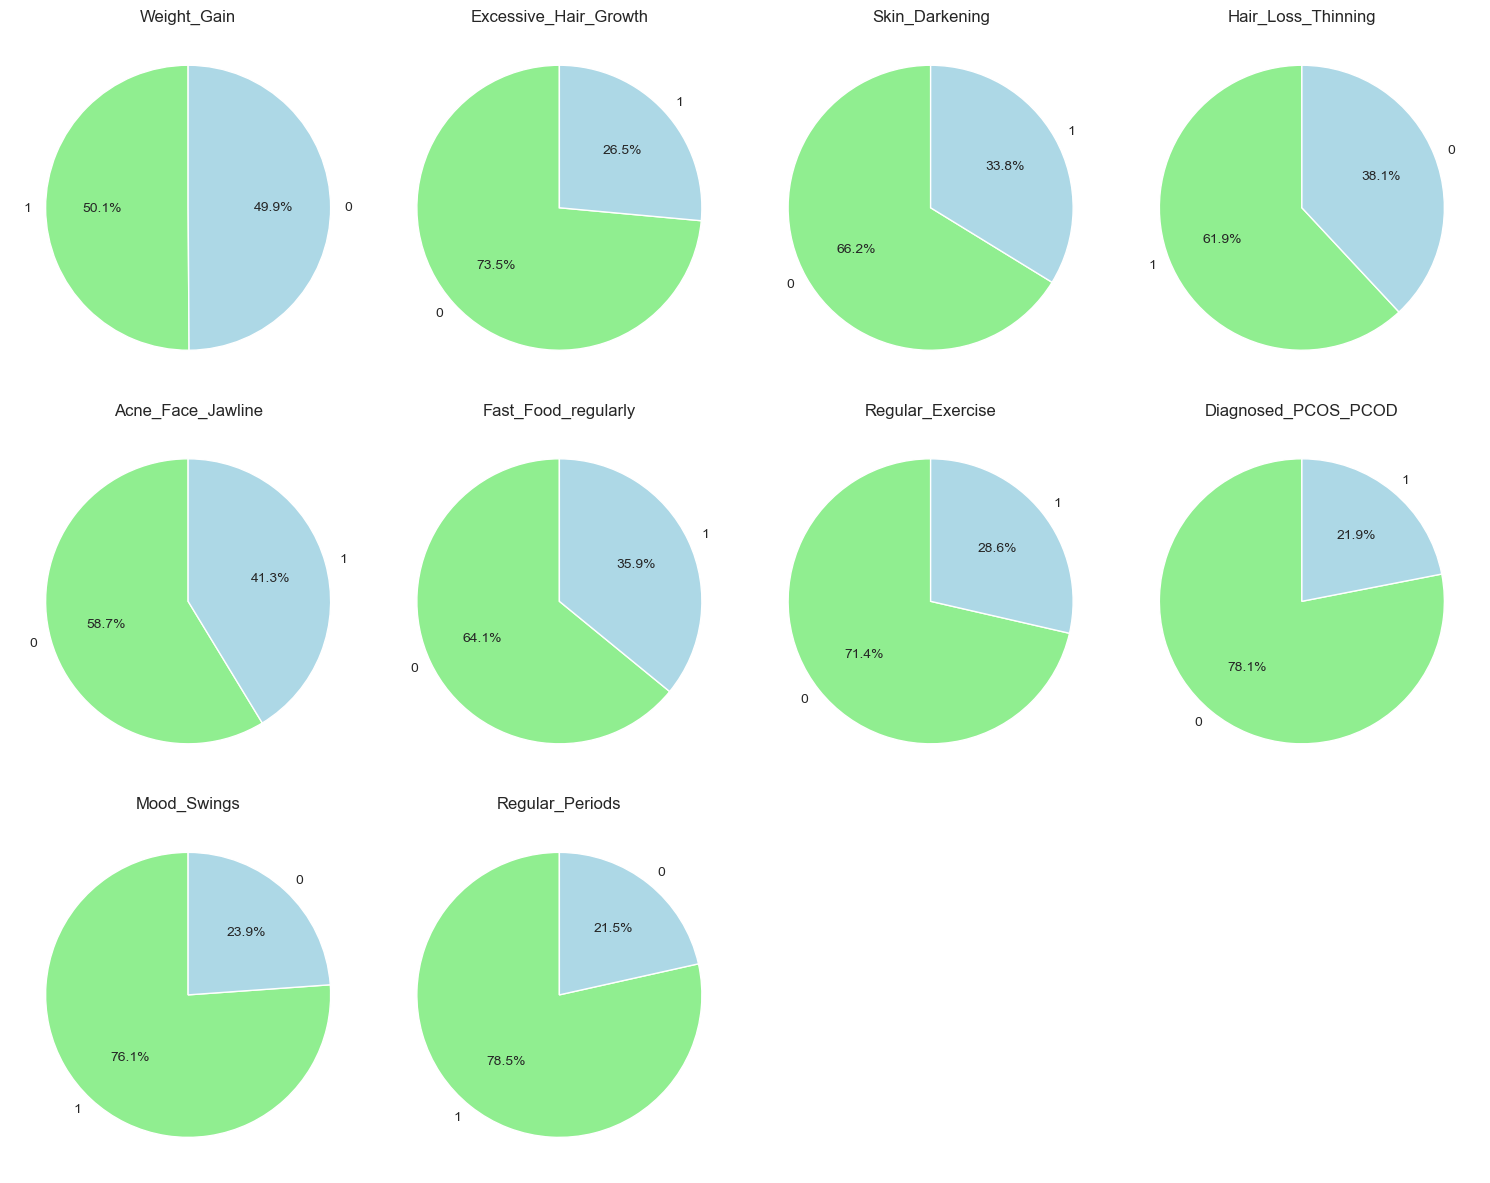

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the figure
plt.figure(figsize=(15, 12))

# List of categorical columns to visualize (excluding months, blood types, and cycle dates)
categorical_columns = [
    'Weight_Gain',
    'Excessive_Hair_Growth',
    'Skin_Darkening',
    'Hair_Loss_Thinning',
    'Acne_Face_Jawline',
    'Fast_Food_regularly',
    'Regular_Exercise',
    'Diagnosed_PCOS_PCOD',
    'Mood_Swings',
    'Regular_Periods'
]

# Create pie chart for each categorical column
for idx, col in enumerate(categorical_columns):
    plt.subplot(3, 4, idx + 1)  # Adjust the subplot layout (3 rows, 4 columns)
    df_survey[col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightblue'], startangle=90, legend=False)
    plt.title(f'{col}')
    plt.ylabel('')

# Adjust layout to avoid overlap
plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.tight_layout()

# Show all the plots
plt.show()


C:\Users\ounin\AppData\Local\Temp\ipykernel_3648\1904461228.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_non_boolean[col], palette='Set2')
C:\Users\ounin\AppData\Local\Temp\ipykernel_3648\1904461228.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_non_boolean[col], palette='Set2')
C:\Users\ounin\AppData\Local\Temp\ipykernel_3648\1904461228.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_non_boolean[col], palette='Set2')


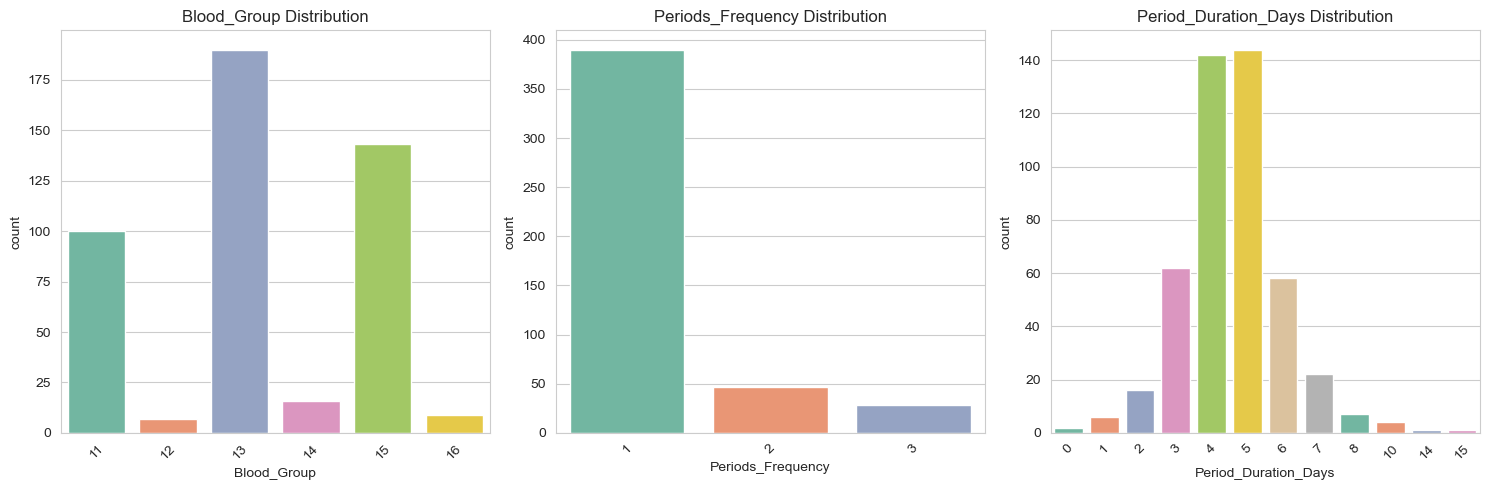

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named df_survey with the mentioned columns

# List of non-boolean columns
non_boolean_columns = [
    'Blood_Group',
    'Periods_Frequency',
    'Period_Duration_Days'
]

df_non_boolean = df_survey[non_boolean_columns]

# Plotting bar charts for each non-boolean column
plt.figure(figsize=(15, 5))

for idx, col in enumerate(df_non_boolean.columns):
    plt.subplot(1, len(df_non_boolean.columns), idx + 1)  # Create subplots in a single row
    sns.countplot(x=df_non_boolean[col], palette='Set2')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

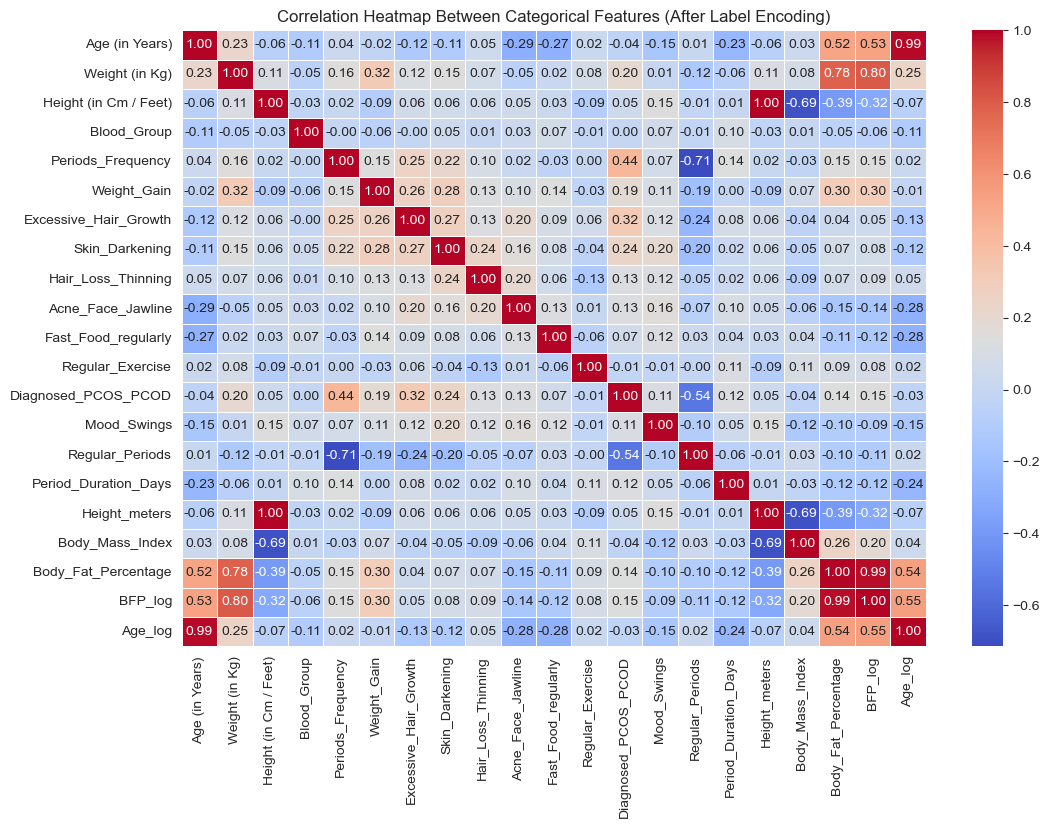

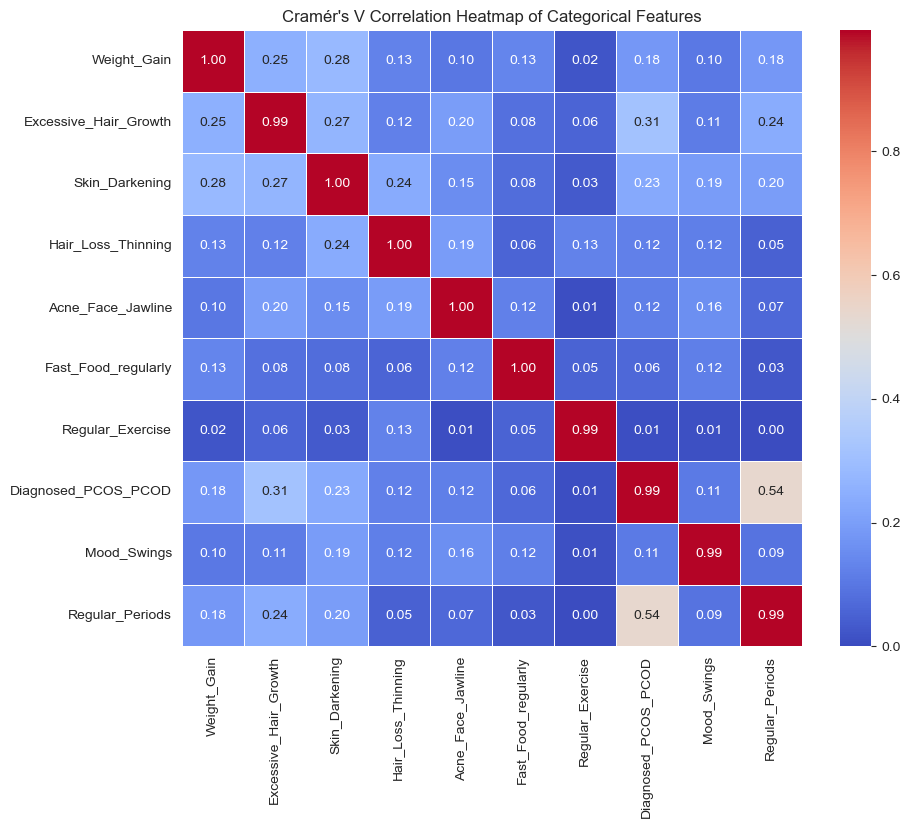

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming df_survey is your DataFrame and contains categorical columns

# List of categorical columns (adjust according to your dataset)
categorical_columns = [
    'Weight_Gain',
    'Excessive_Hair_Growth',
    'Skin_Darkening',
    'Hair_Loss_Thinning',
    'Acne_Face_Jawline',
    'Fast_Food_regularly',
    'Regular_Exercise',
    'Diagnosed_PCOS_PCOD',
    'Mood_Swings',
    'Regular_Periods'
]

def cramers_v(confusion_matrix):
    """Calculates Cramér's V statistic for categorical-categorical association."""
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # Total number of observations
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))
    
# Compute the correlation matrix
corr_matrix = df_survey[:].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap Between Categorical Features (After Label Encoding)")

cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        # Create a cross-tabulation (contingency table)
        conf_matrix = pd.crosstab(df_survey[col1], df_survey[col2])
        
        # Calculate Cramér's V and fill in the matrix
        cramers_v_matrix.loc[col1, col2] = cramers_v(conf_matrix)

# Convert the correlation matrix to float for plotting
cramers_v_matrix = cramers_v_matrix.astype(float)

# Plotting the Cramér's V heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Correlation Heatmap of Categorical Features")



plt.show()


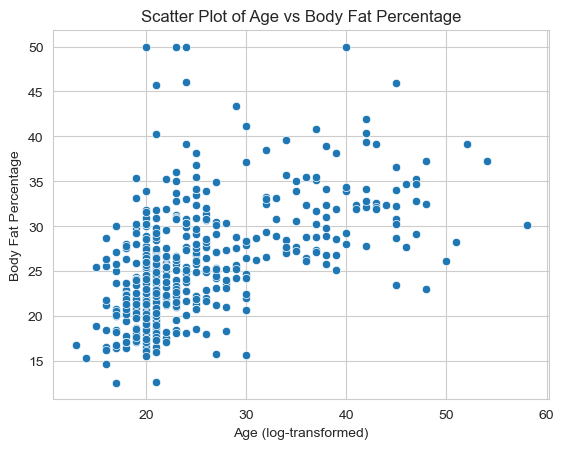

In [119]:

sns.scatterplot(x='Age (in Years)', y='Body_Fat_Percentage', data=df_survey)
plt.title('Scatter Plot of Age vs Body Fat Percentage')
plt.xlabel('Age (log-transformed)')
plt.ylabel('Body Fat Percentage')
plt.show()


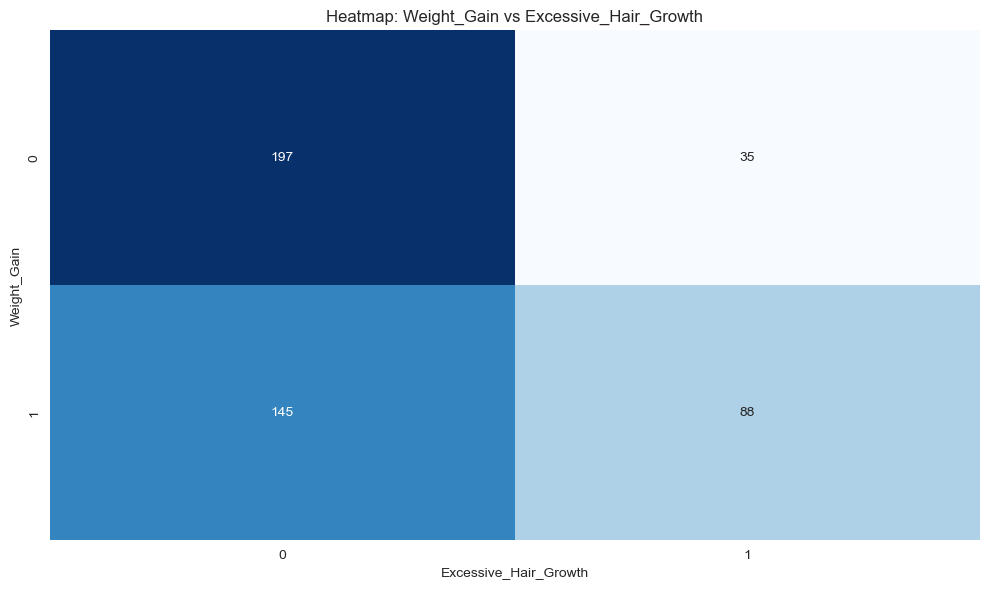

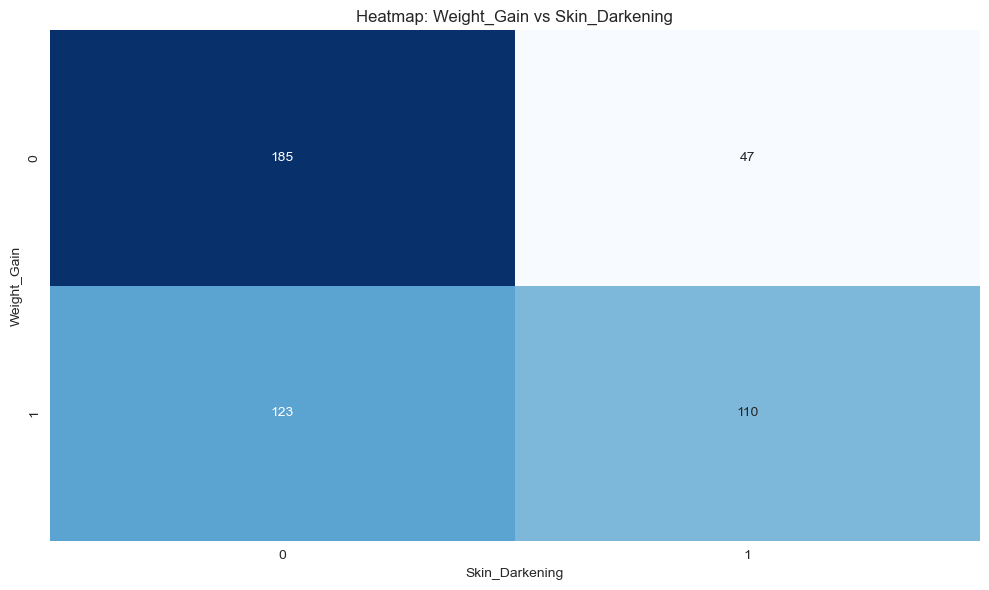

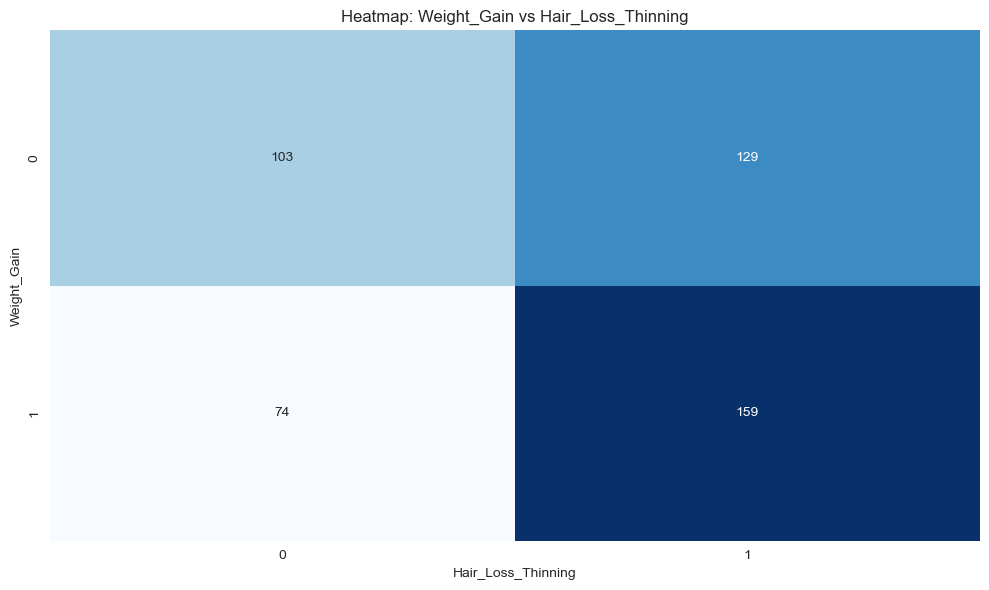

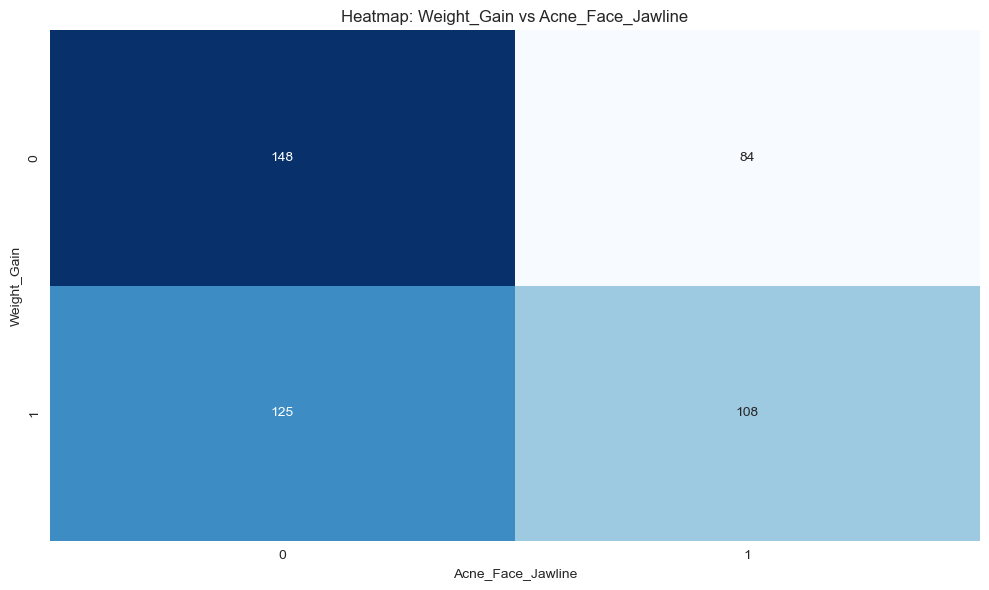

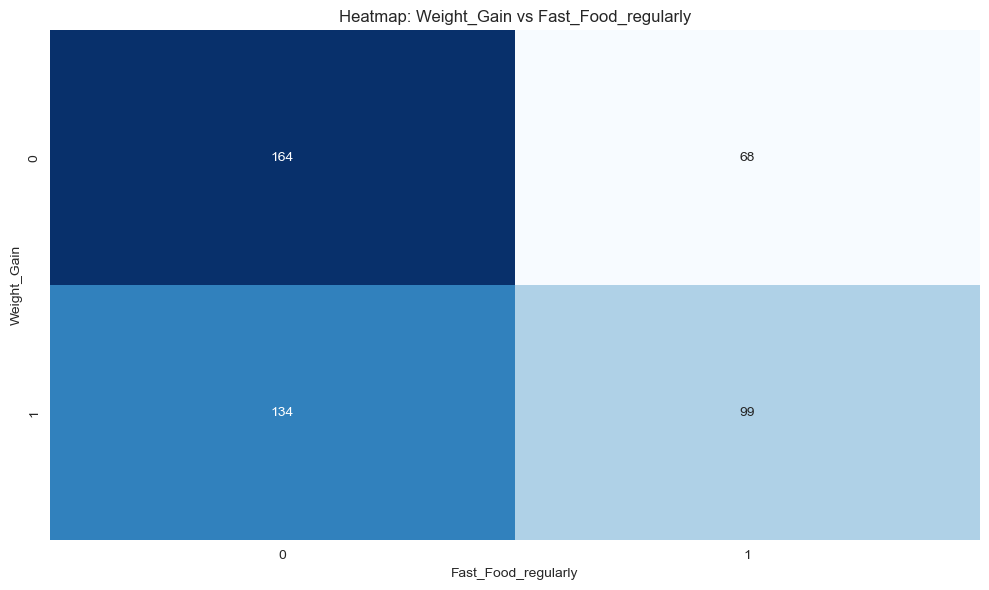

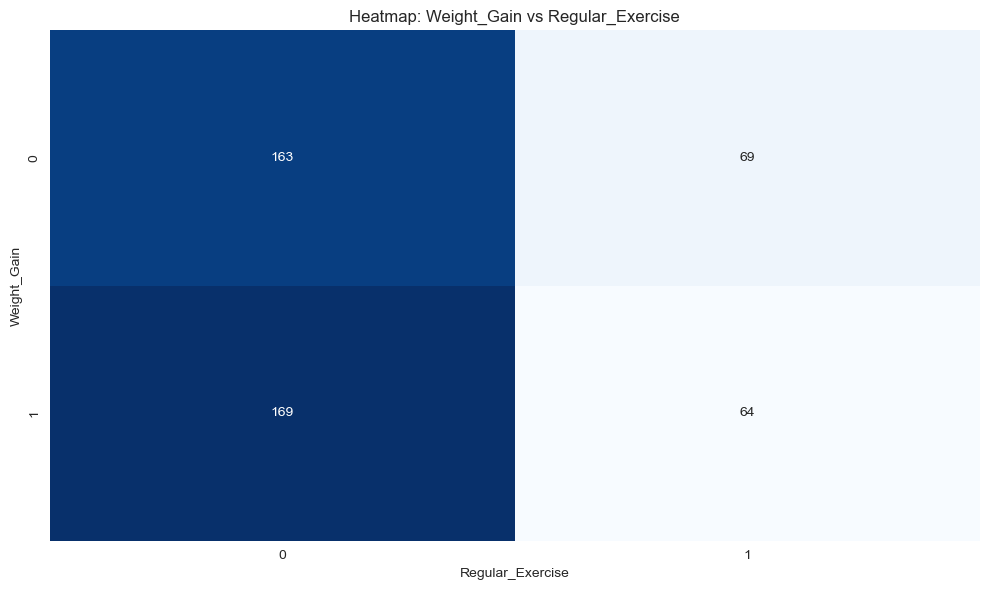

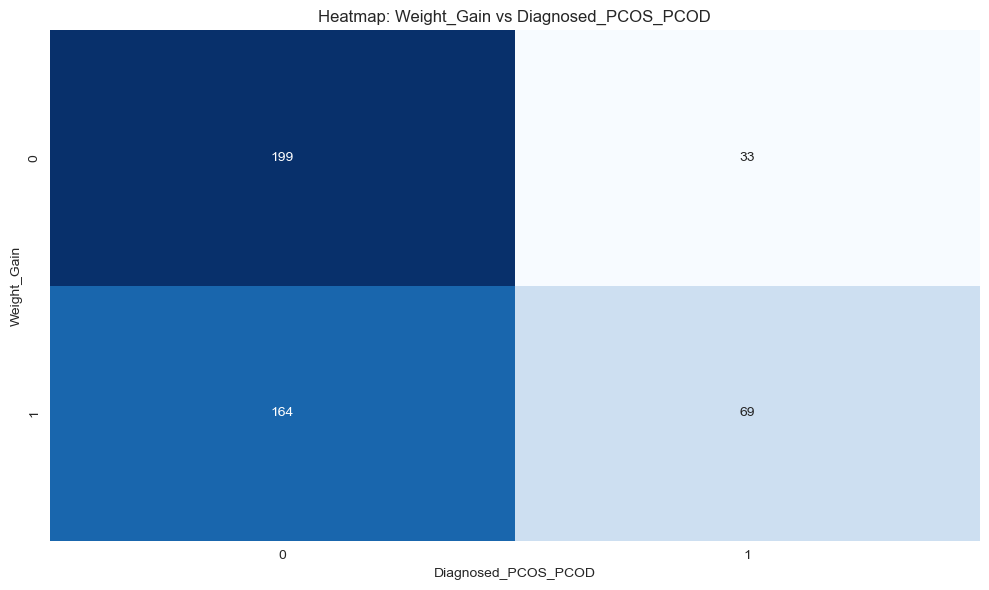

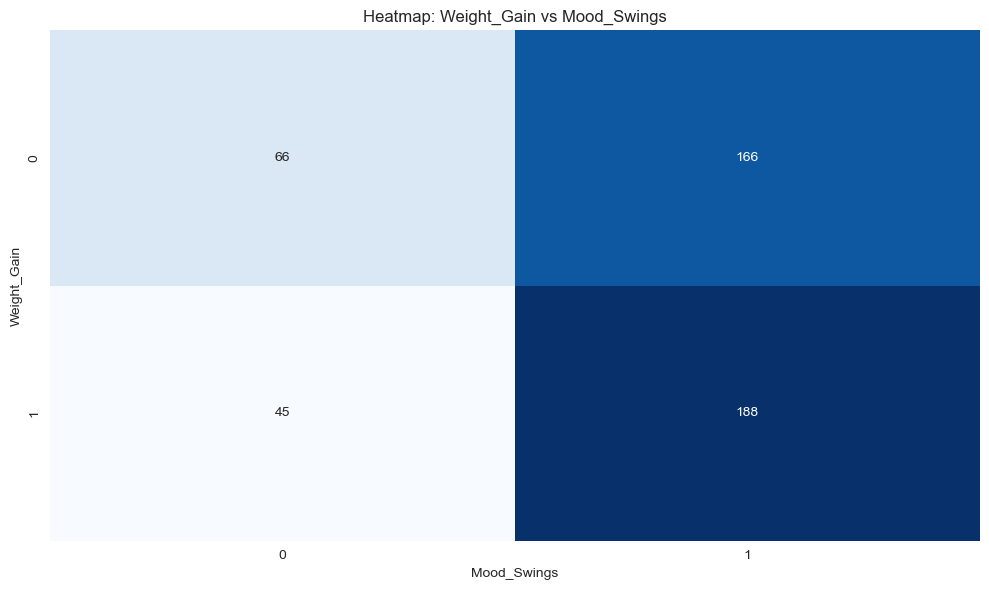

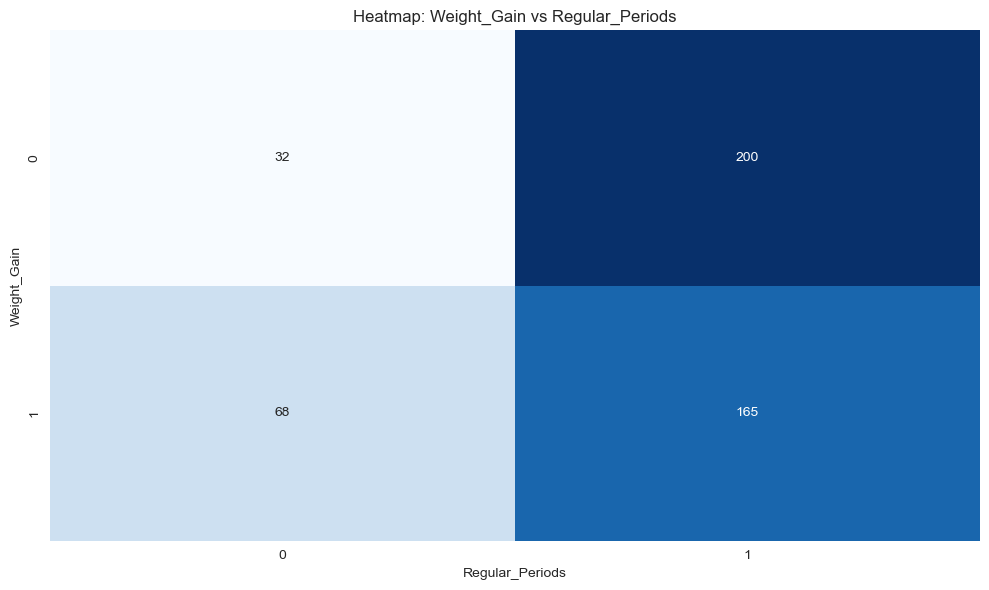

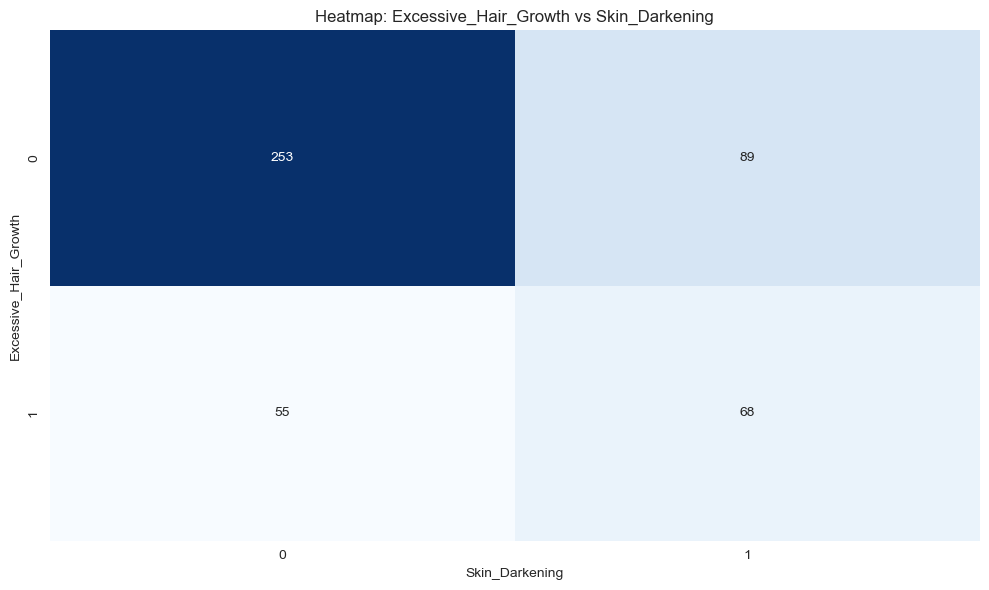

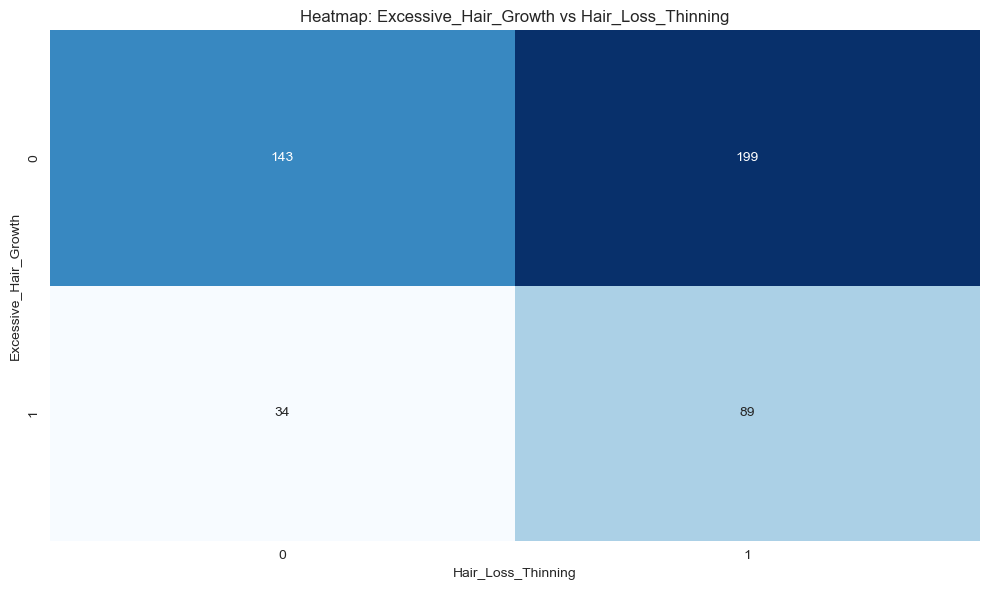

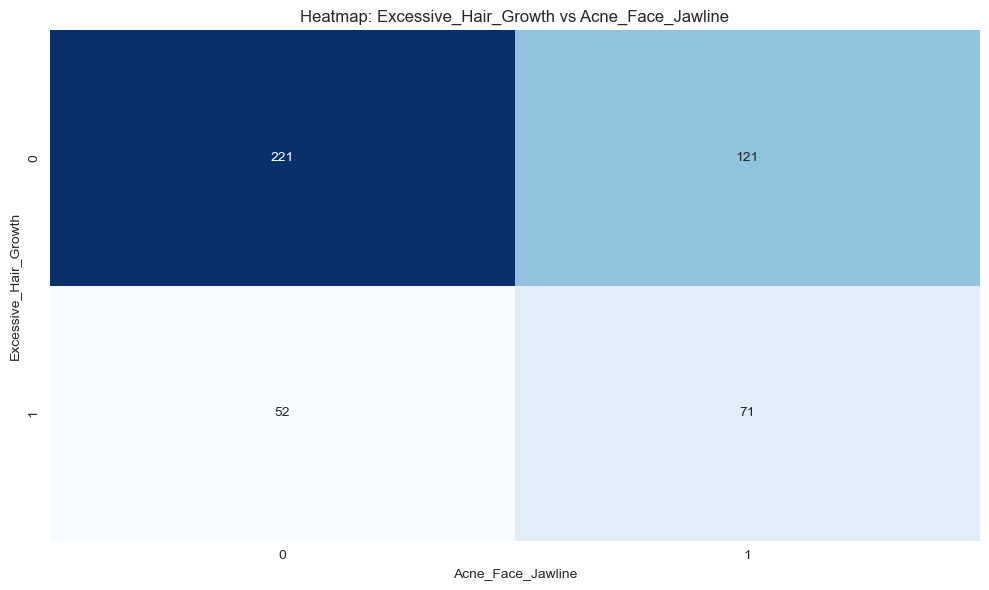

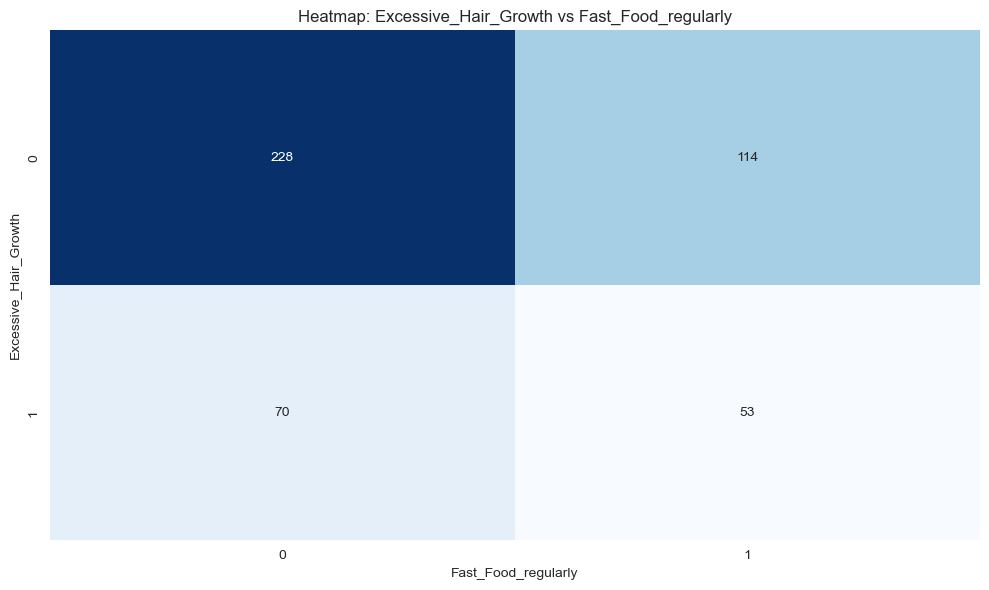

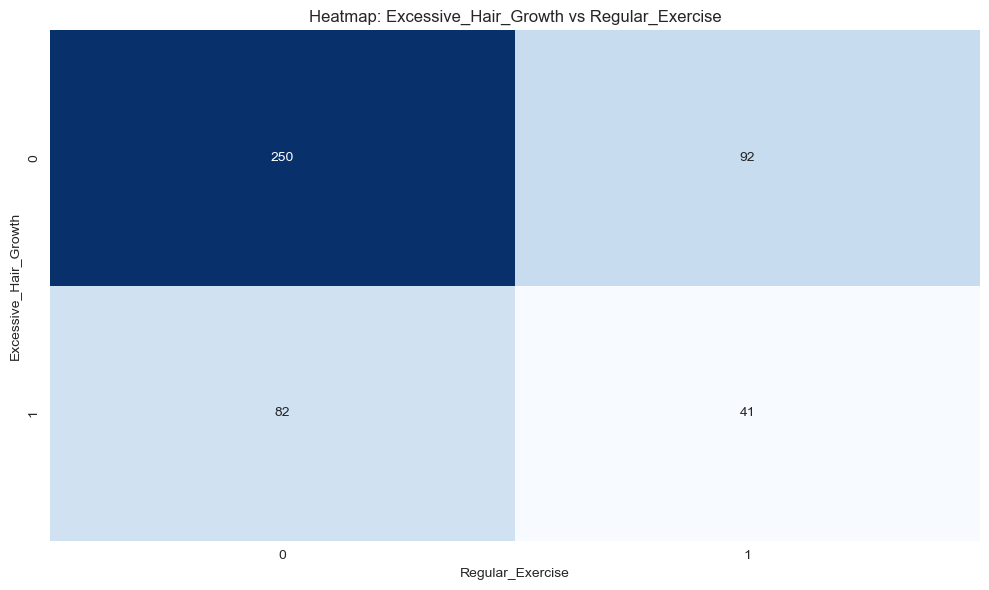

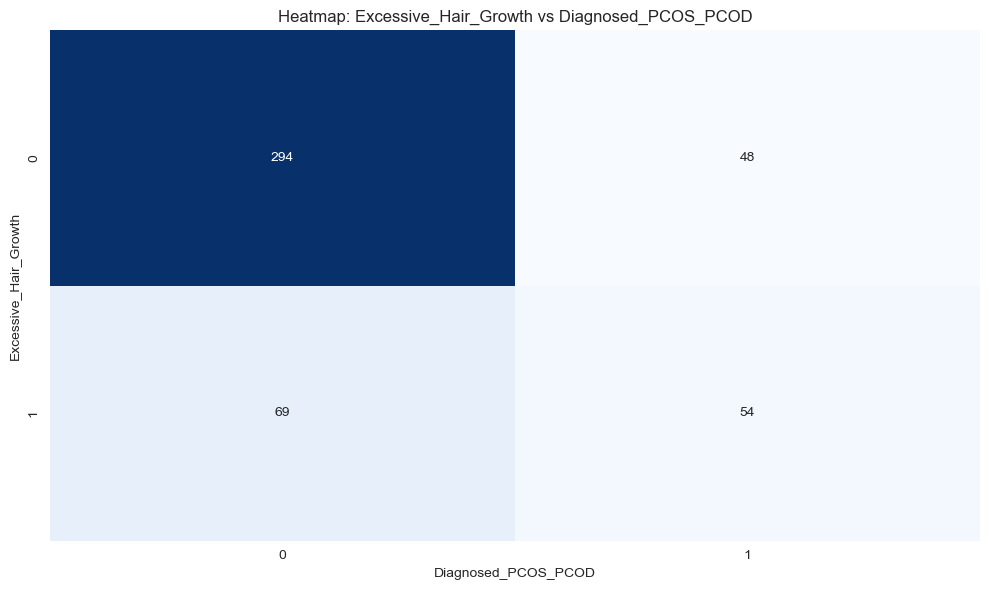

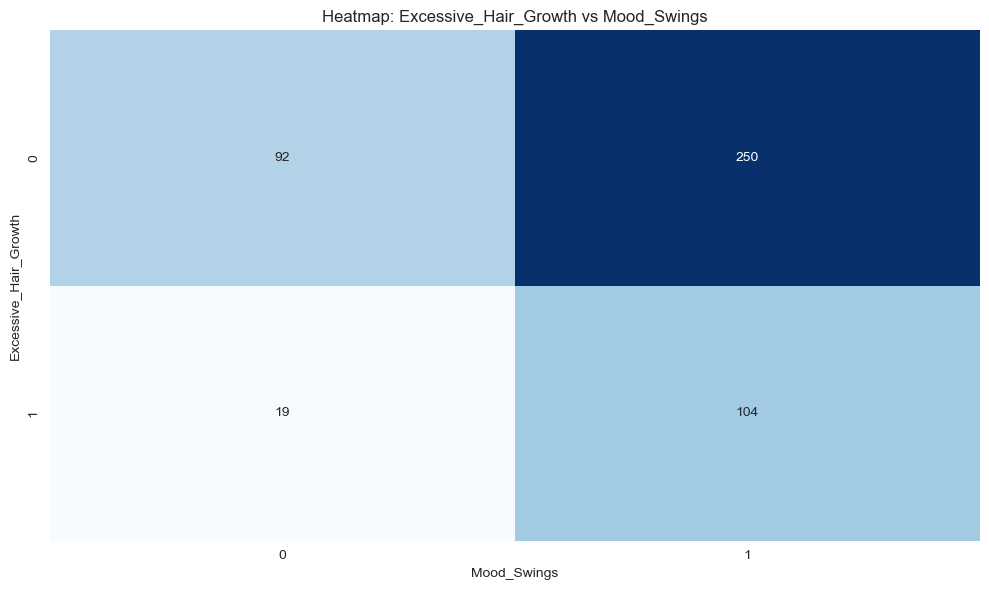

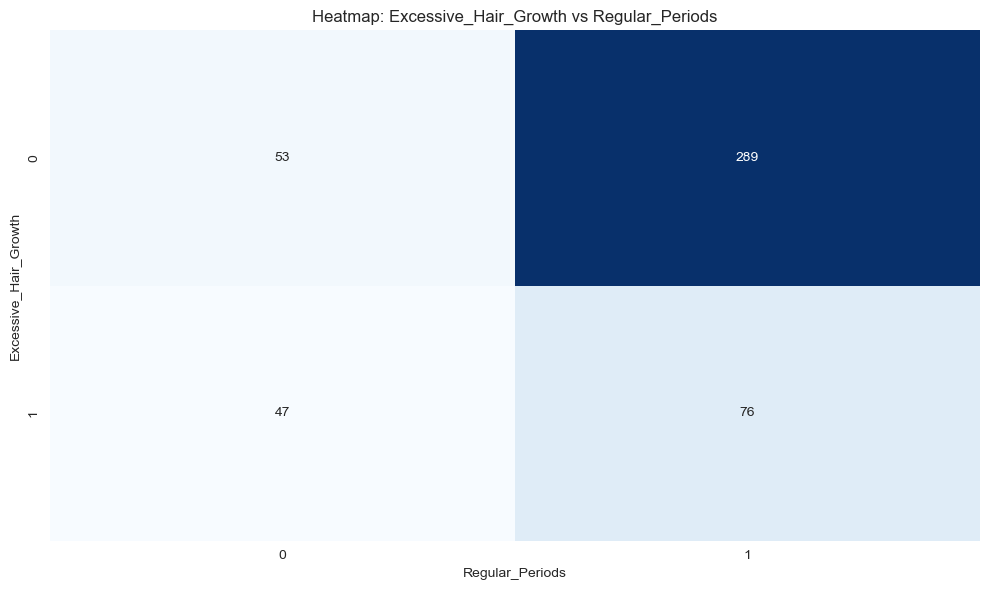

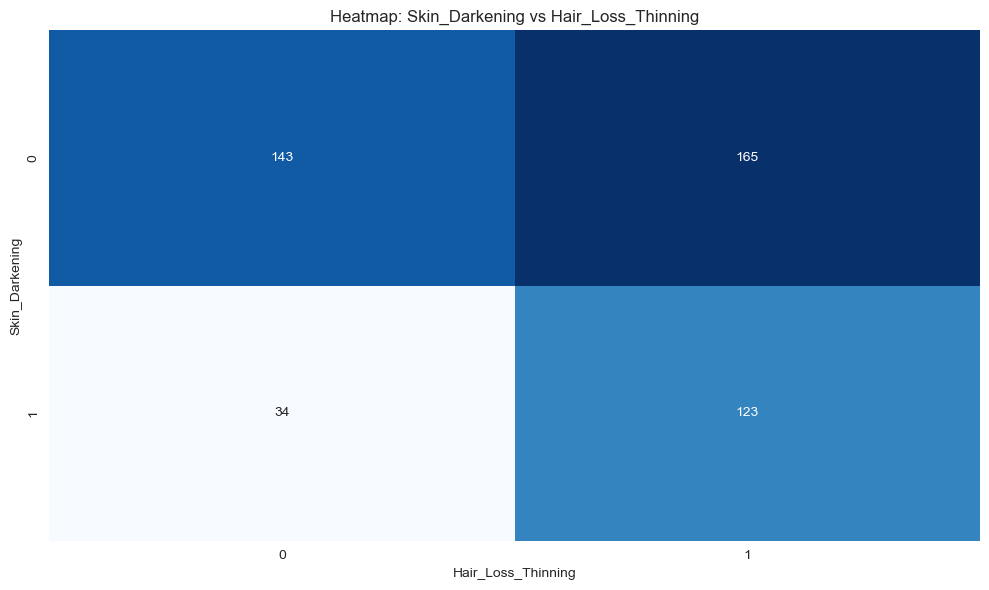

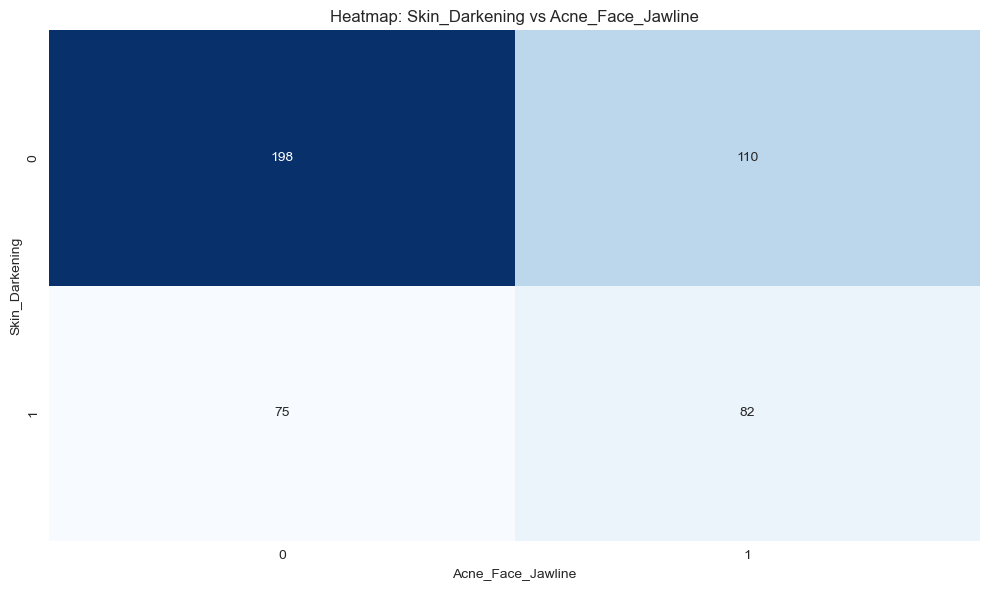

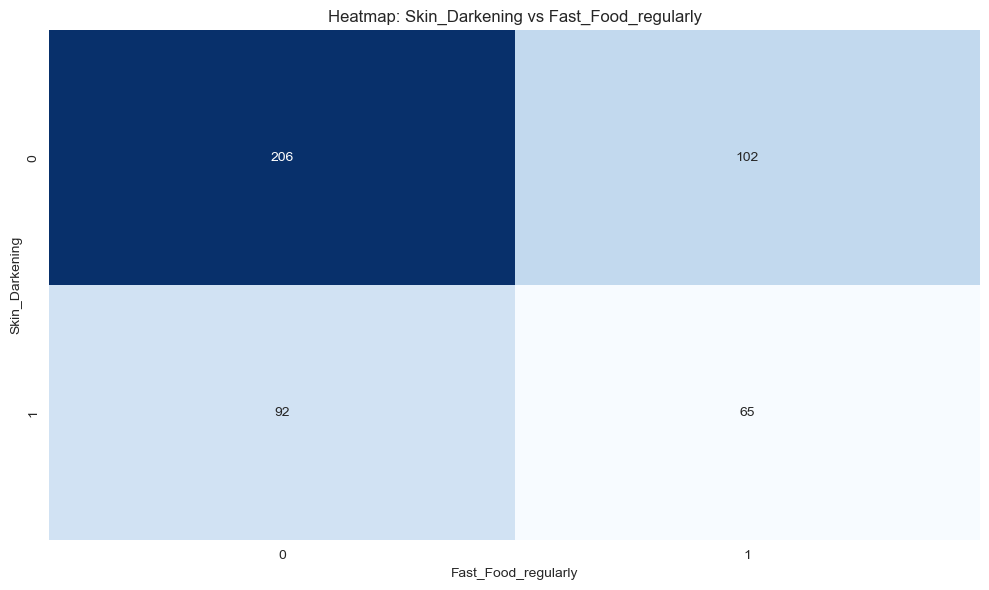

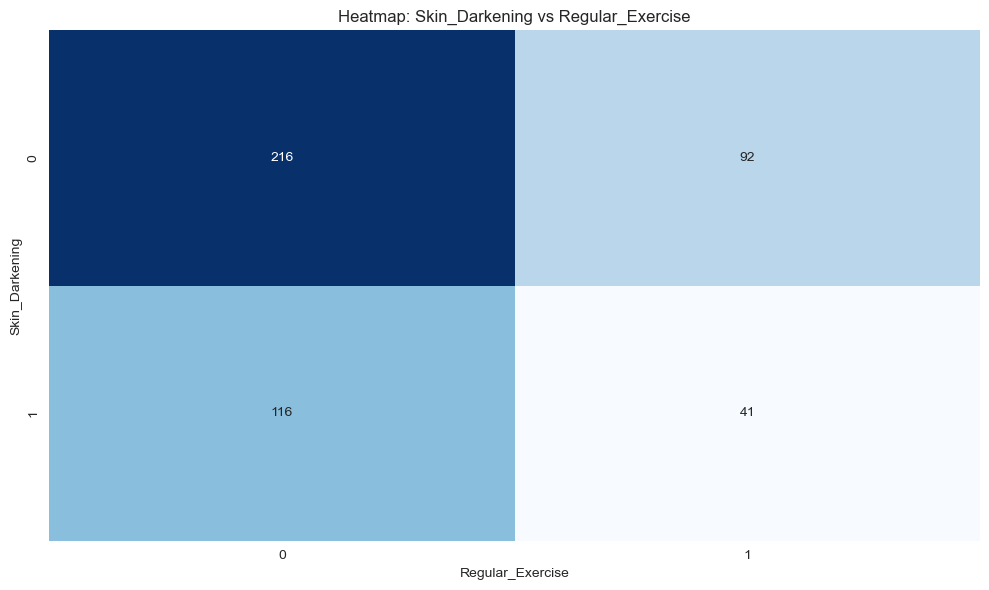

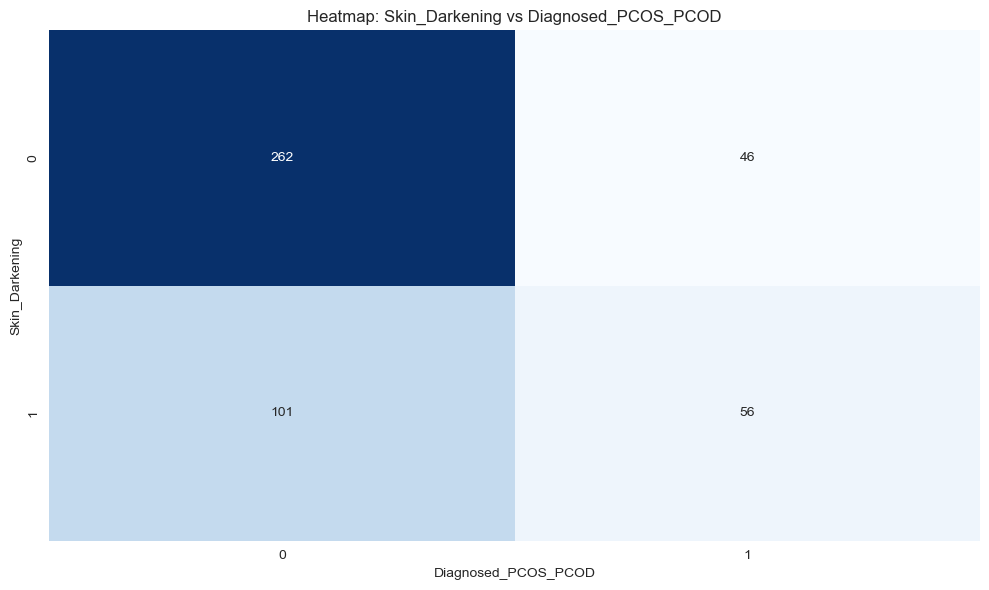

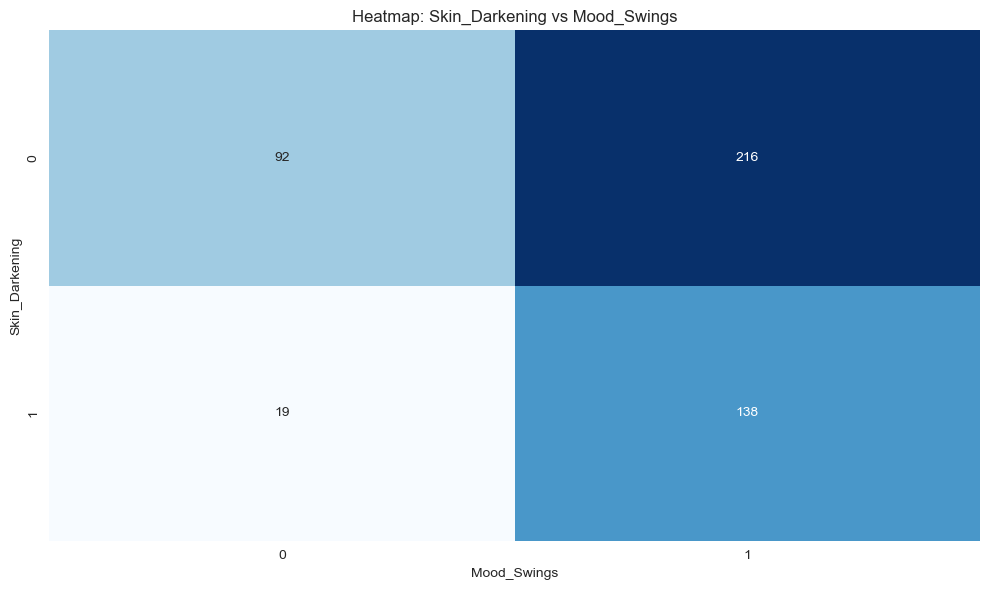

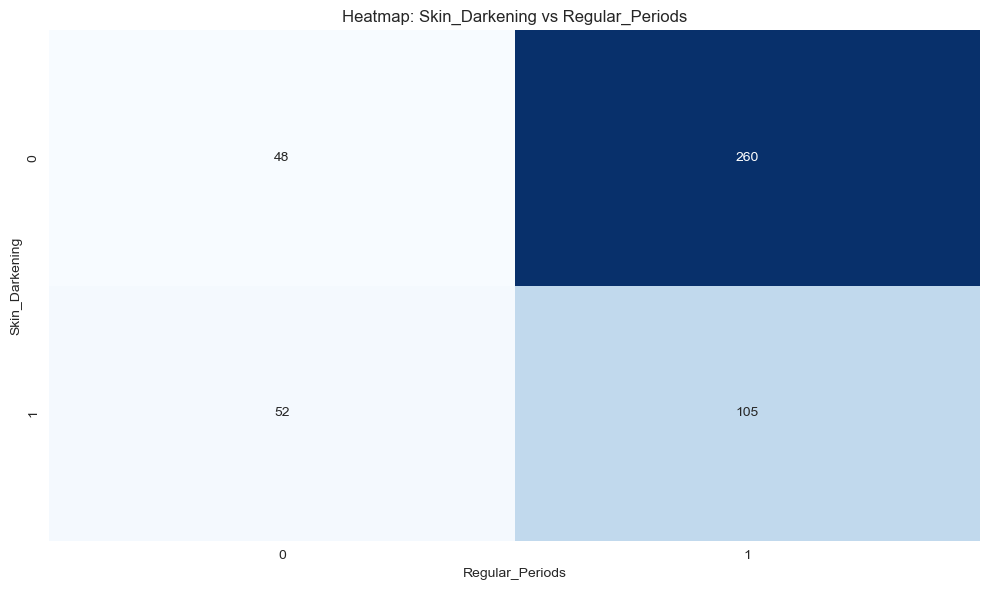

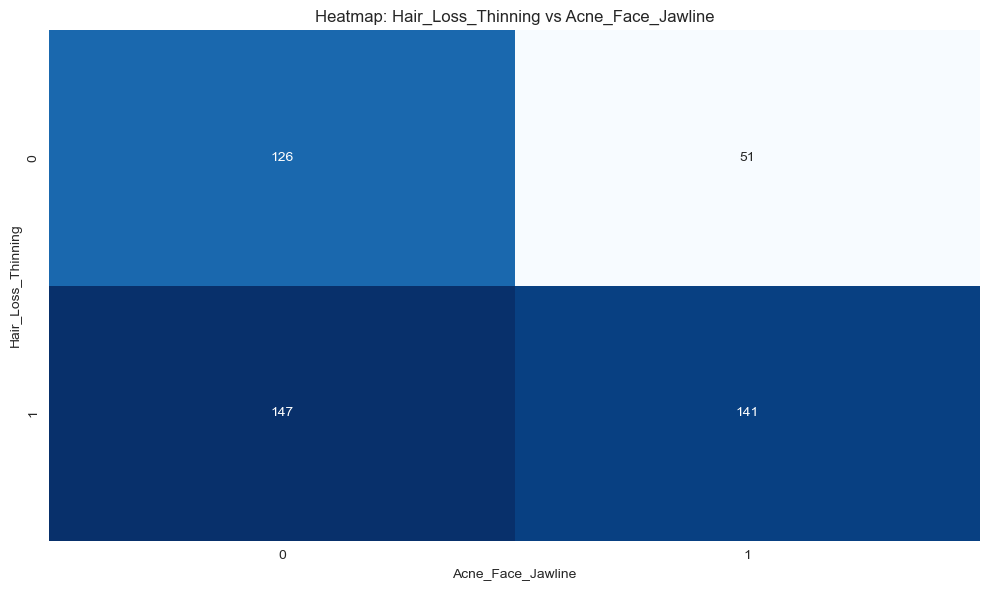

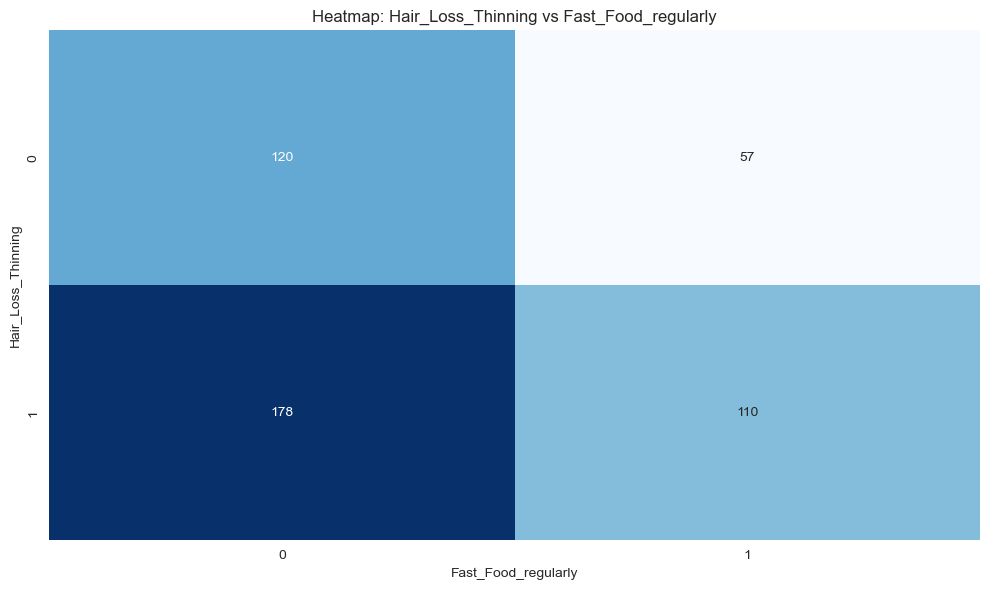

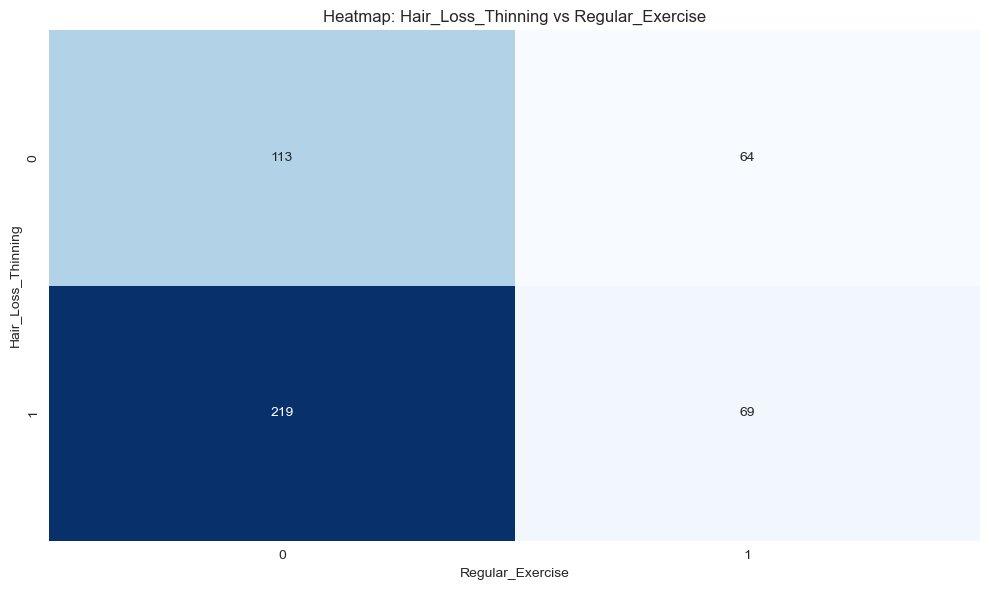

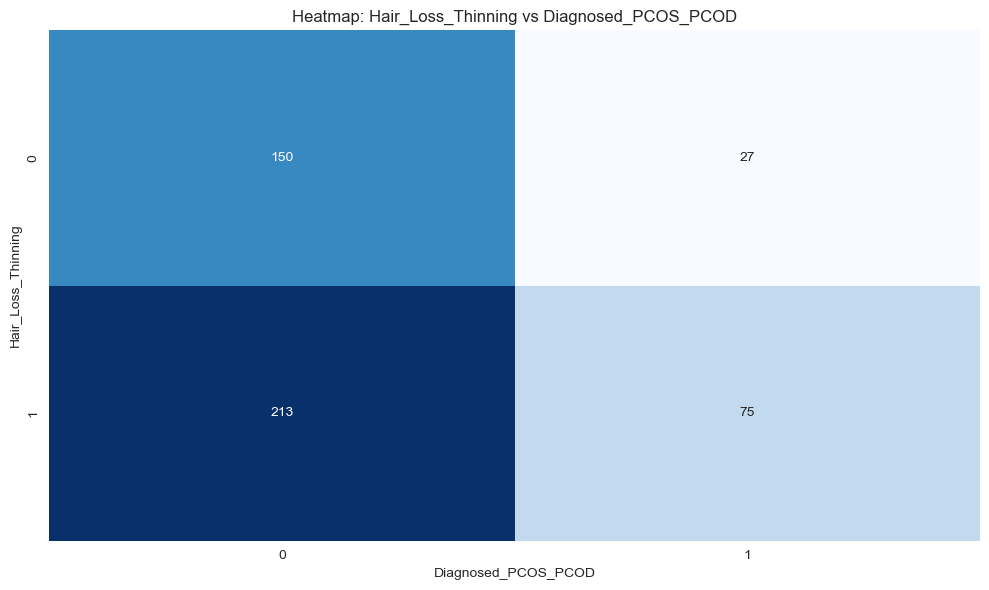

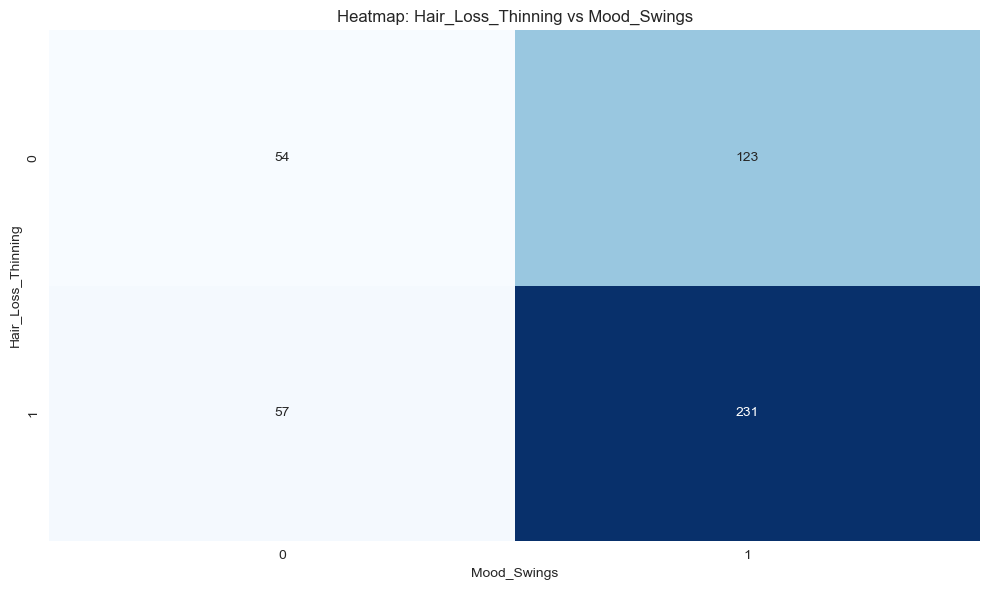

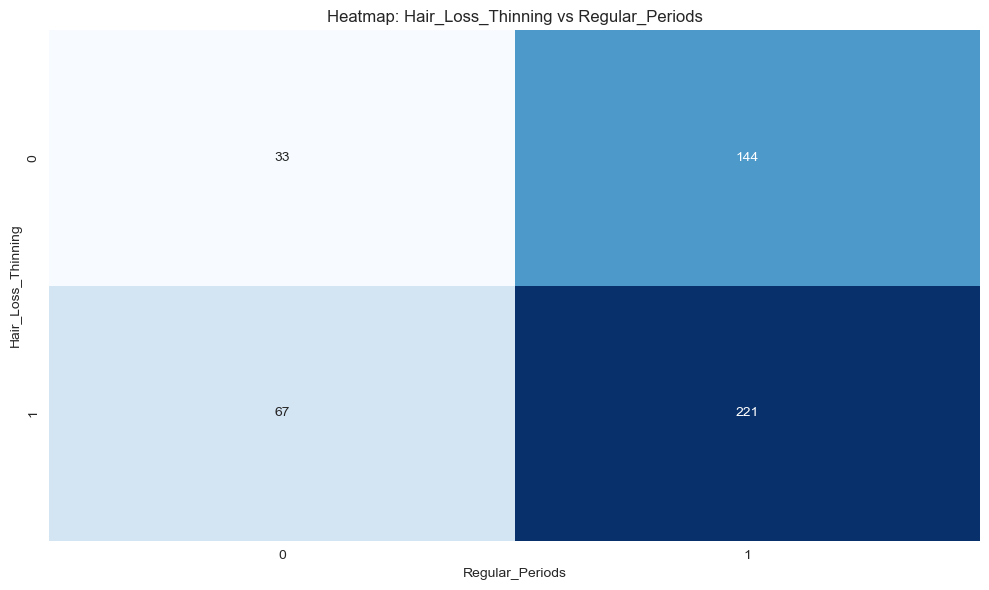

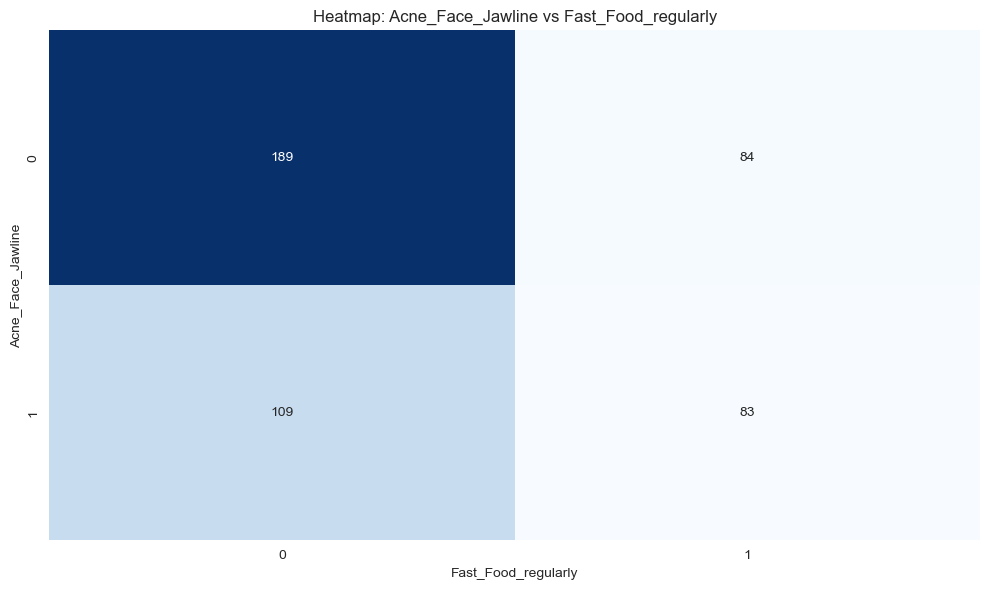

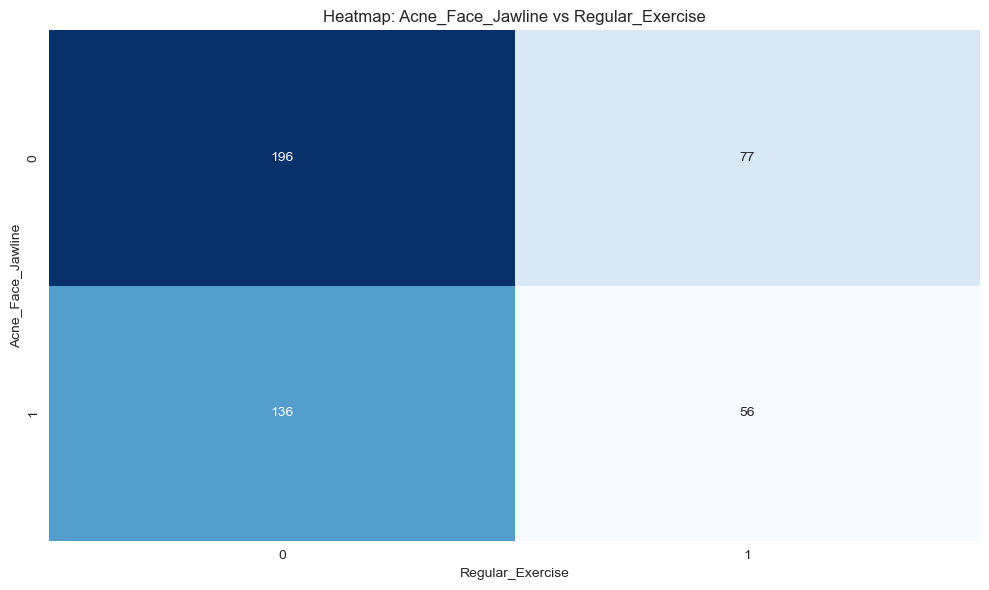

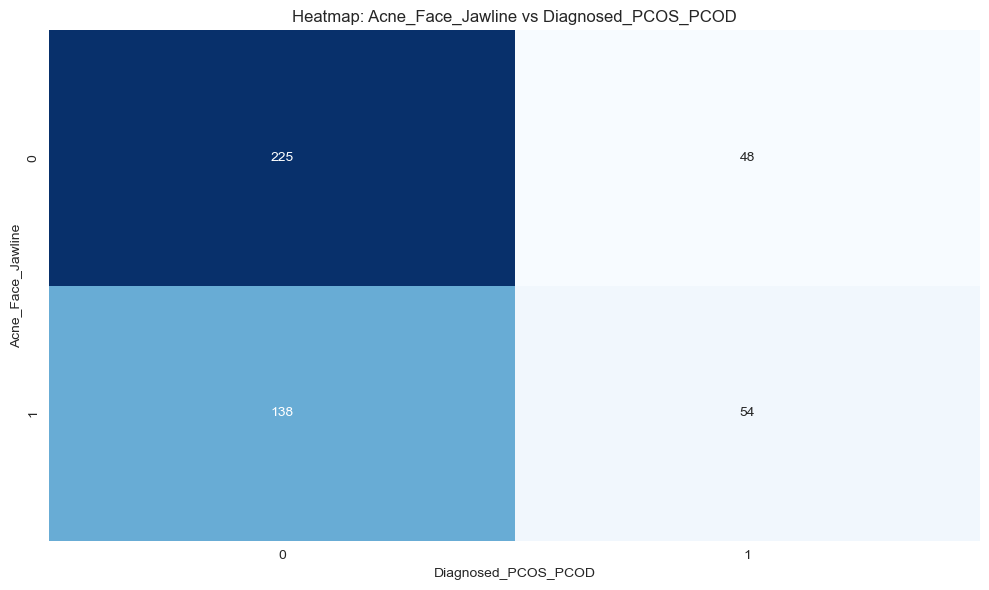

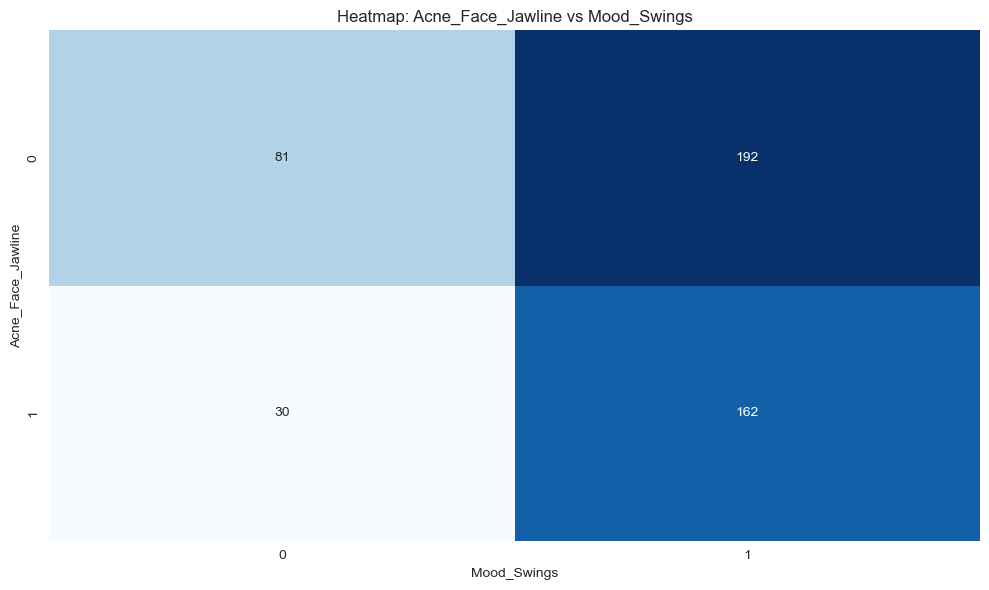

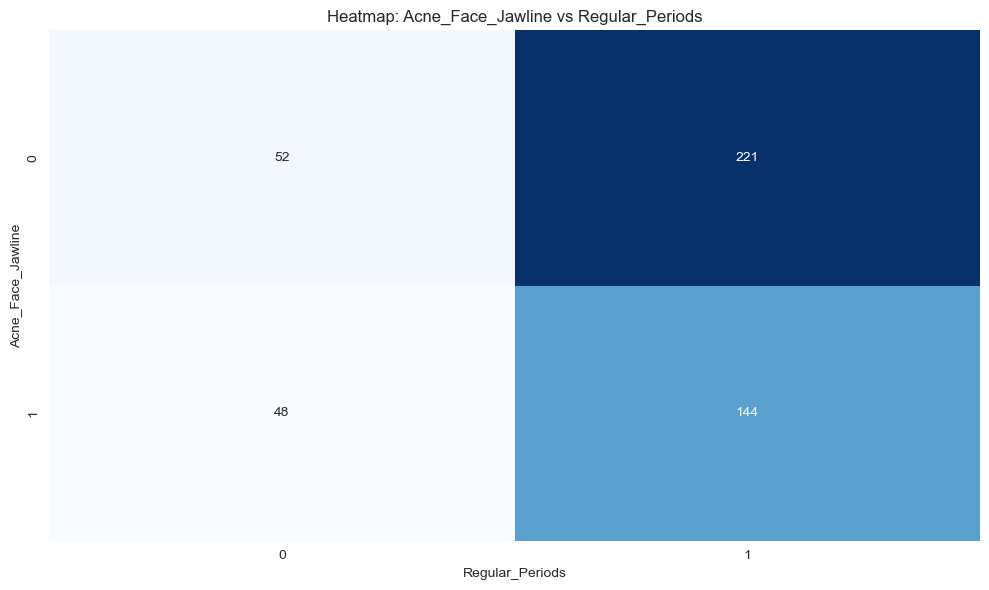

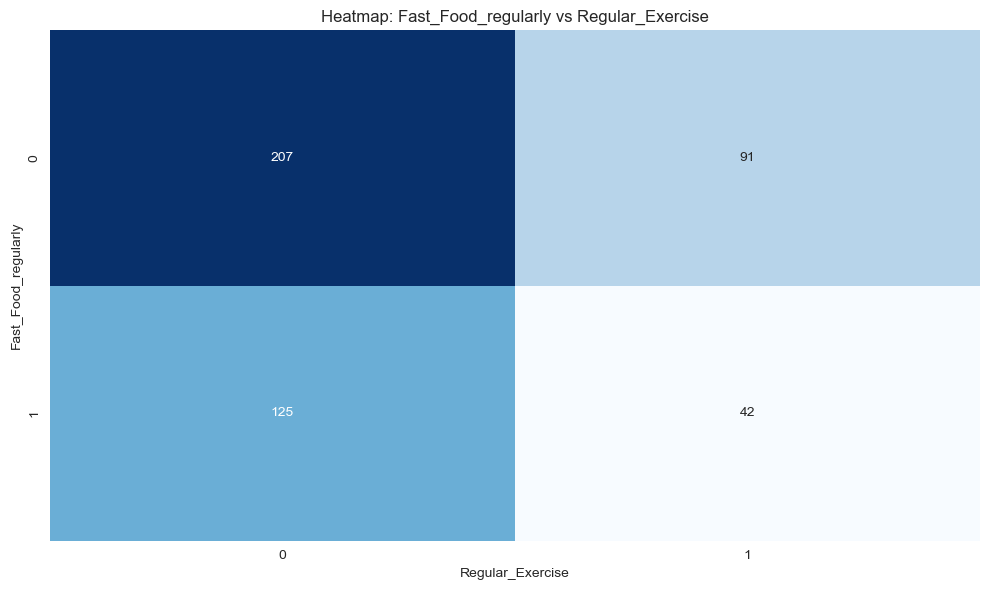

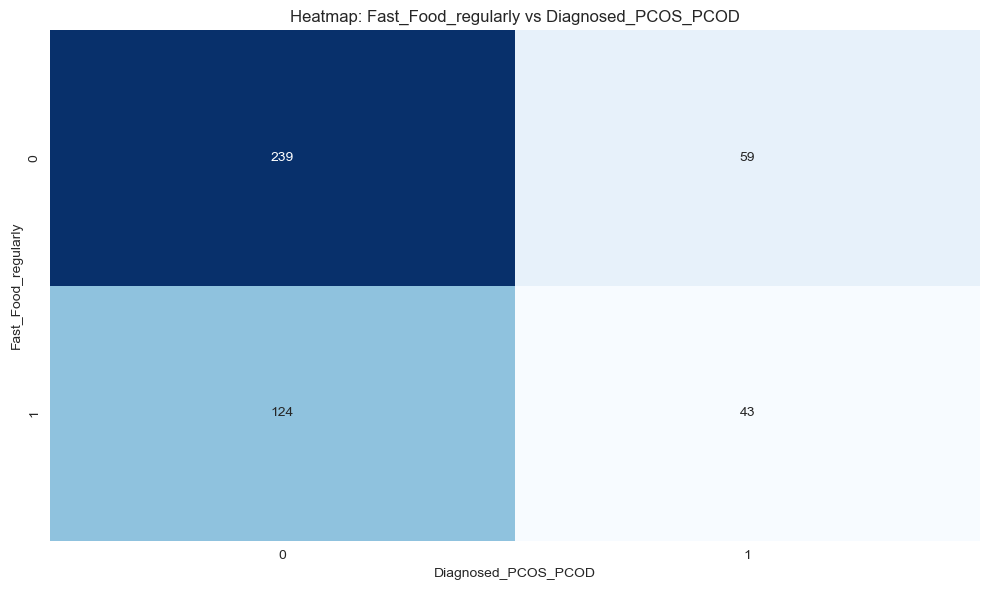

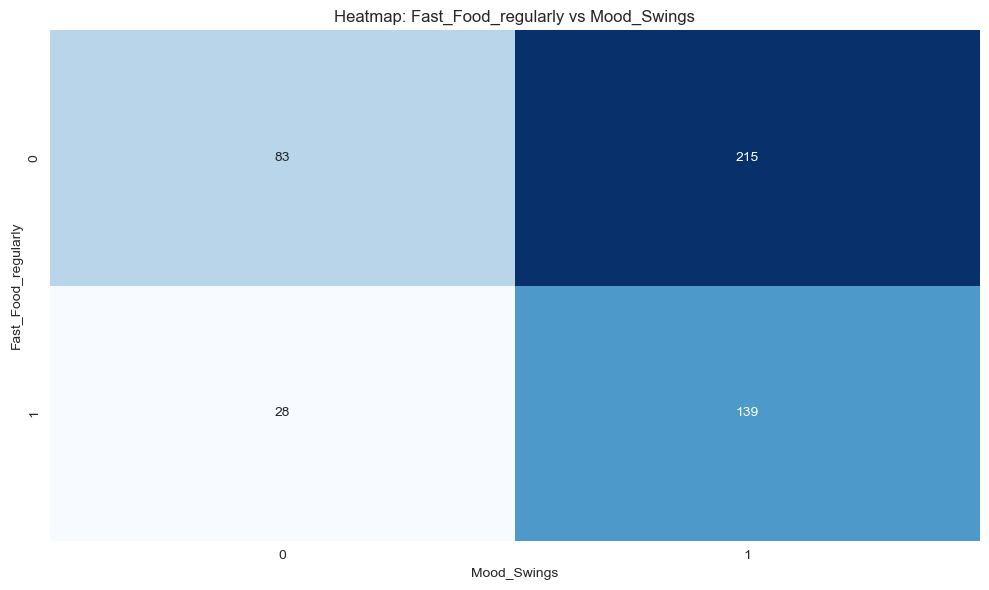

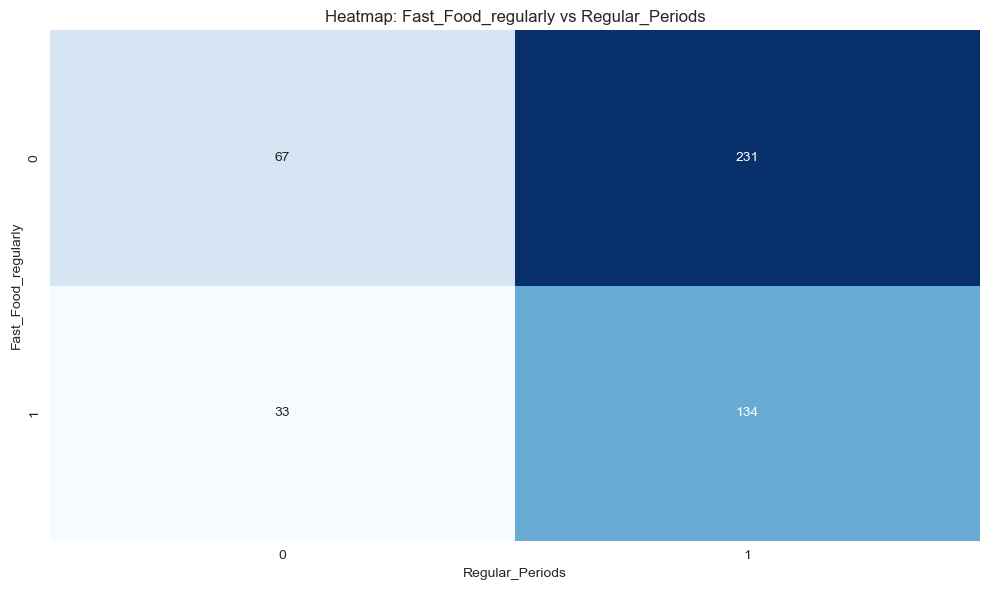

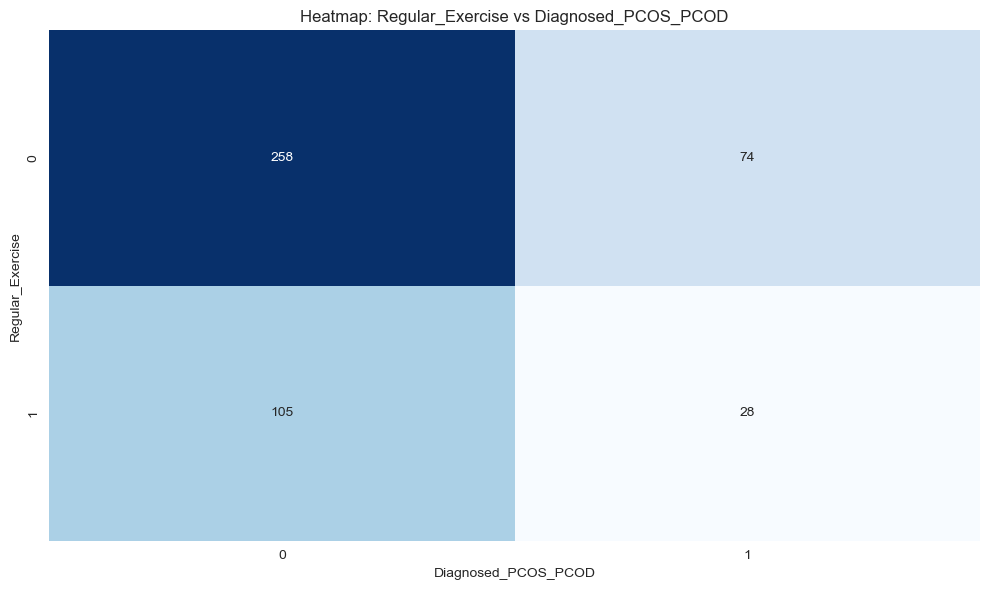

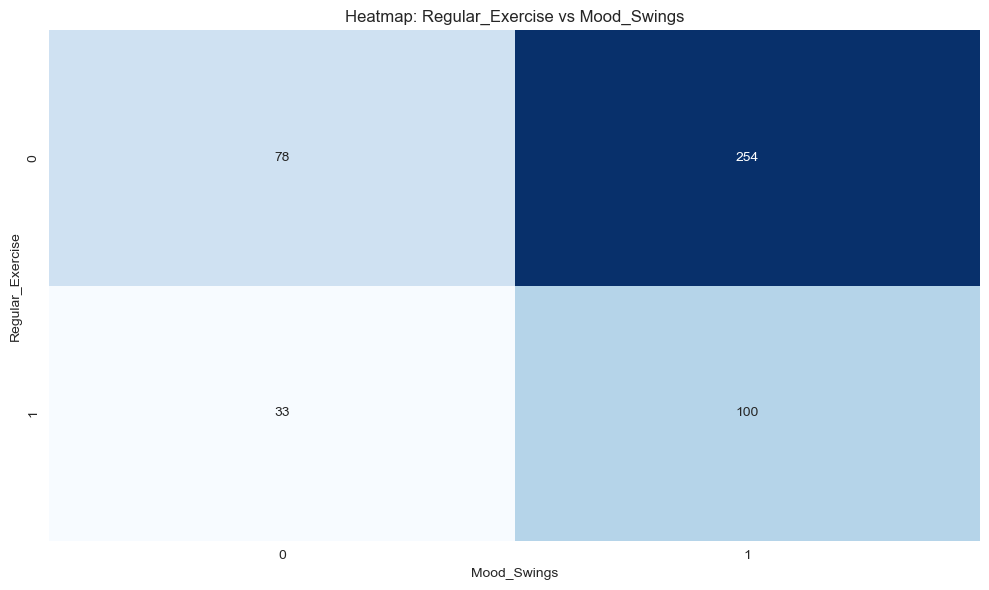

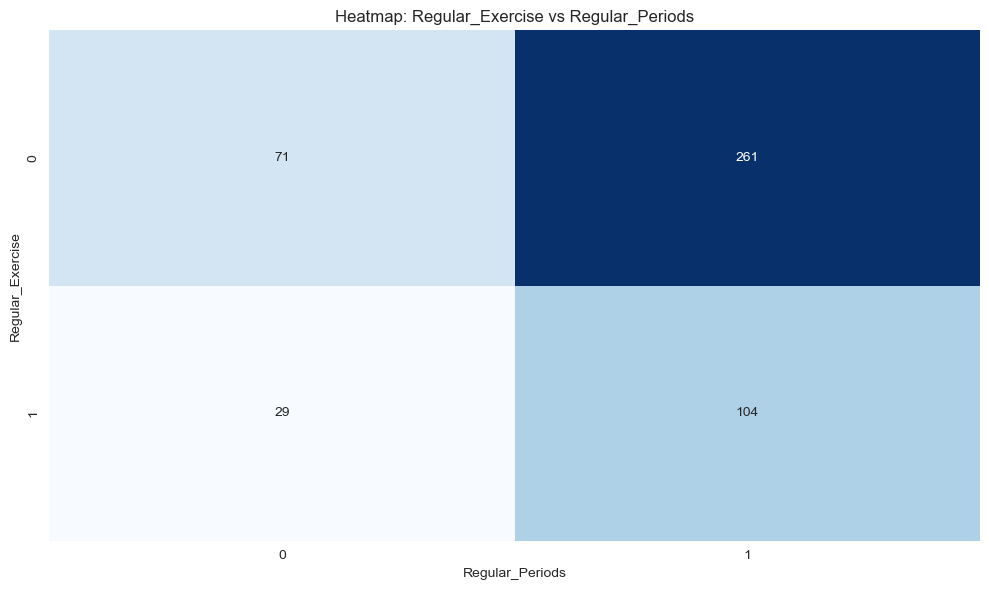

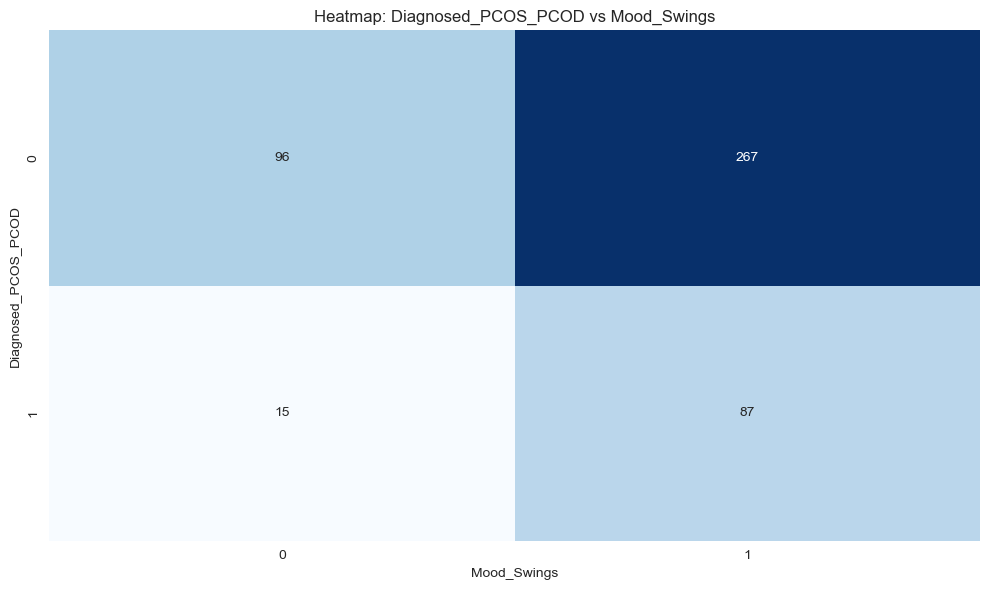

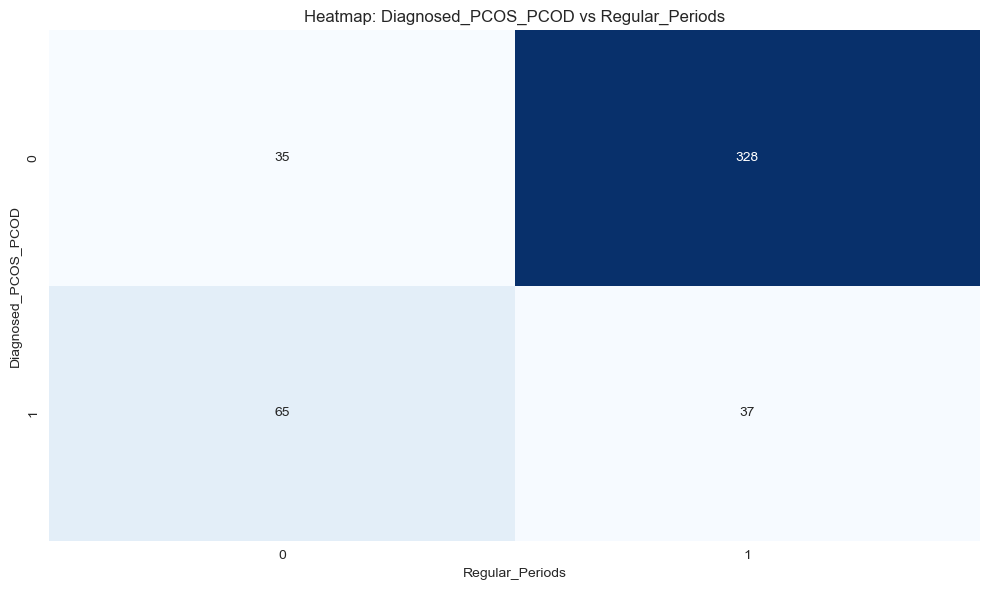

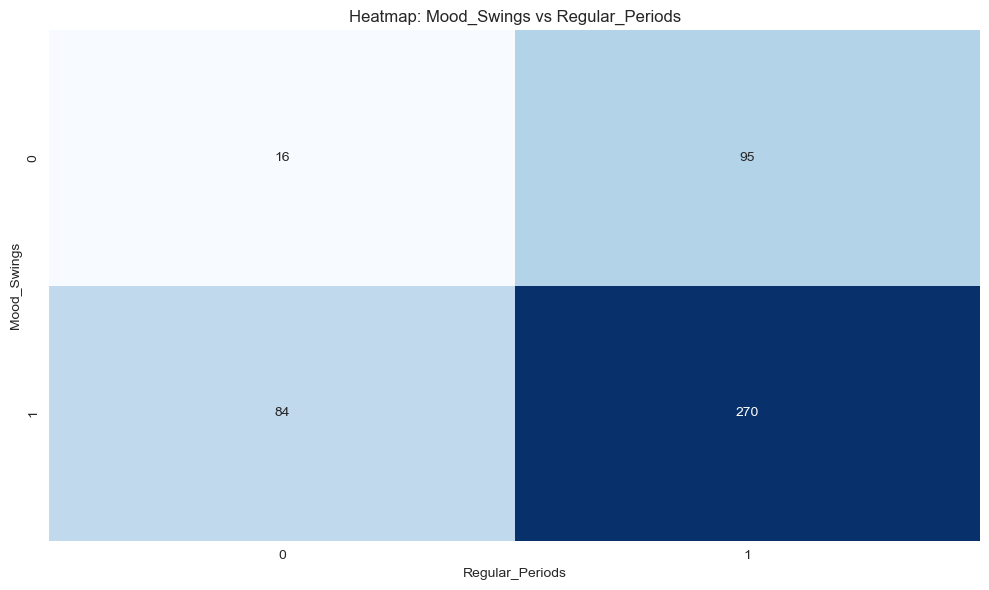

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop over pairs of categorical columns
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        
        # Cross-tabulate the two variables
        crosstab = pd.crosstab(df_survey[col1], df_survey[col2])

        # Create the heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(crosstab, annot=True, cmap='Blues', fmt='d', cbar=False)
        plt.title(f'Heatmap: {col1} vs {col2}')
        plt.xlabel(col2)
        plt.ylabel(col1)
        plt.tight_layout()
        plt.show()


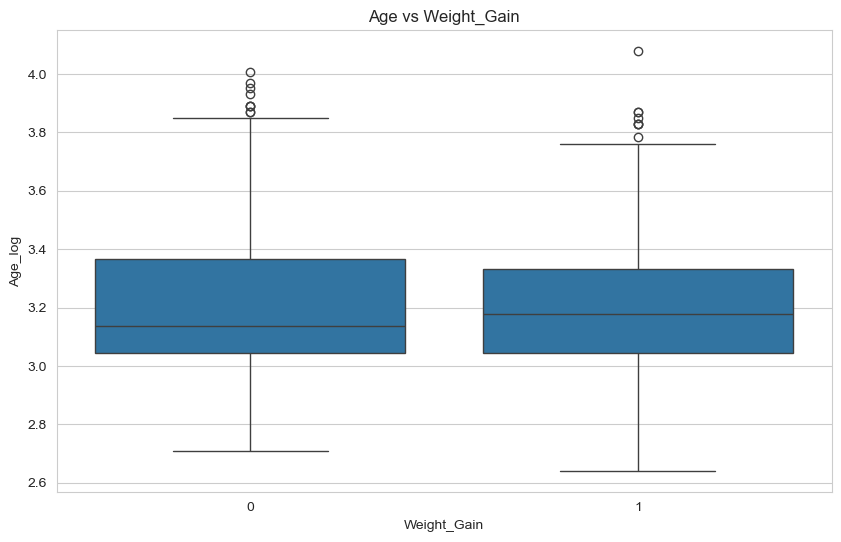

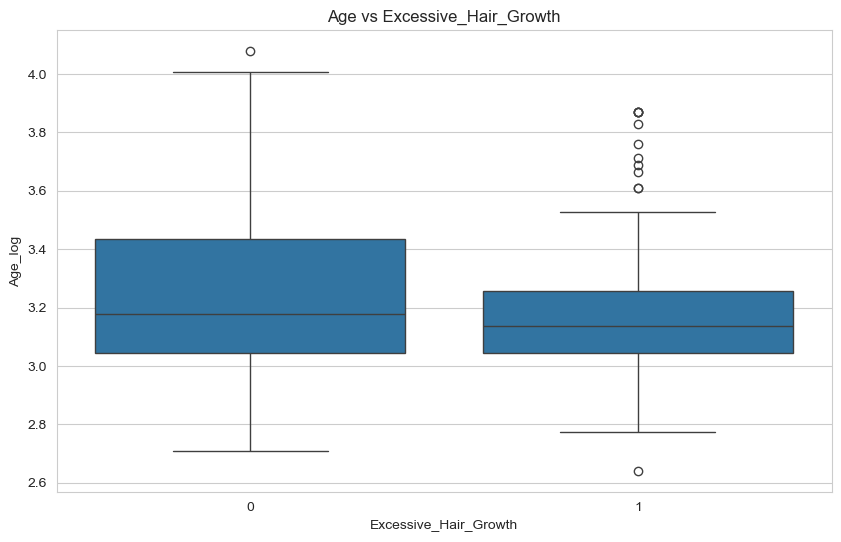

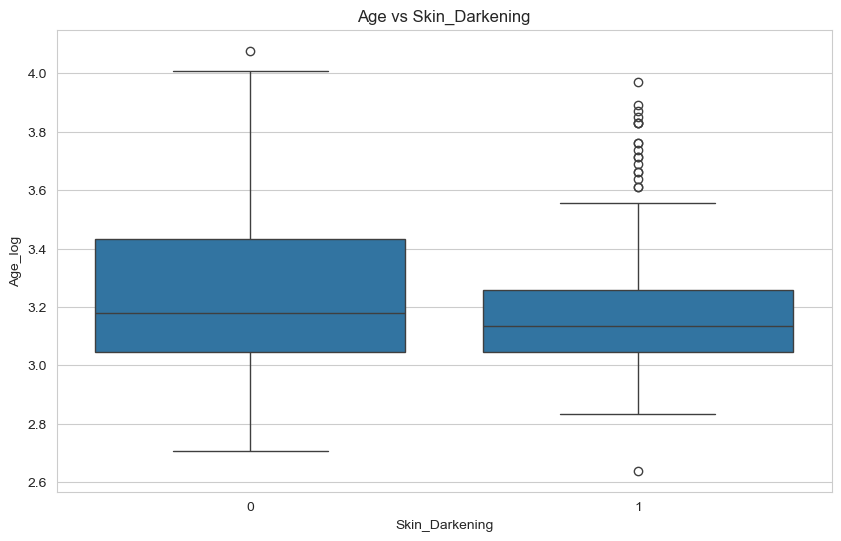

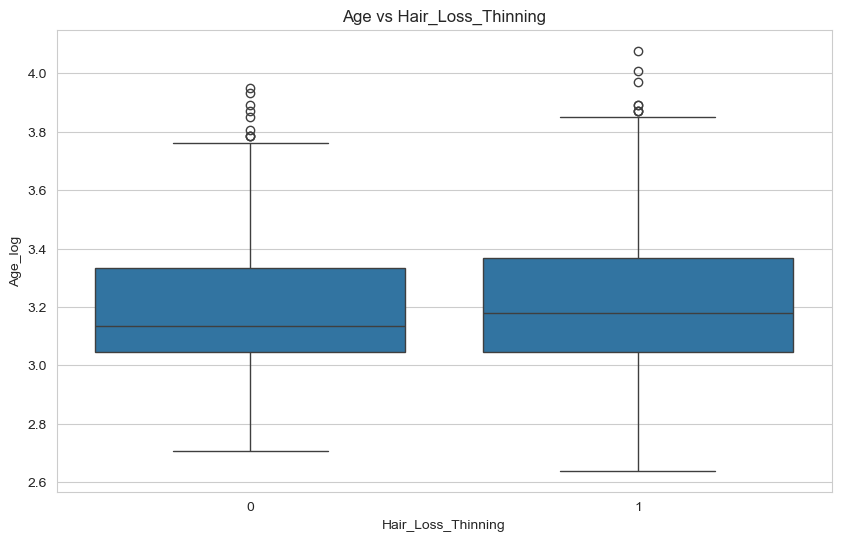

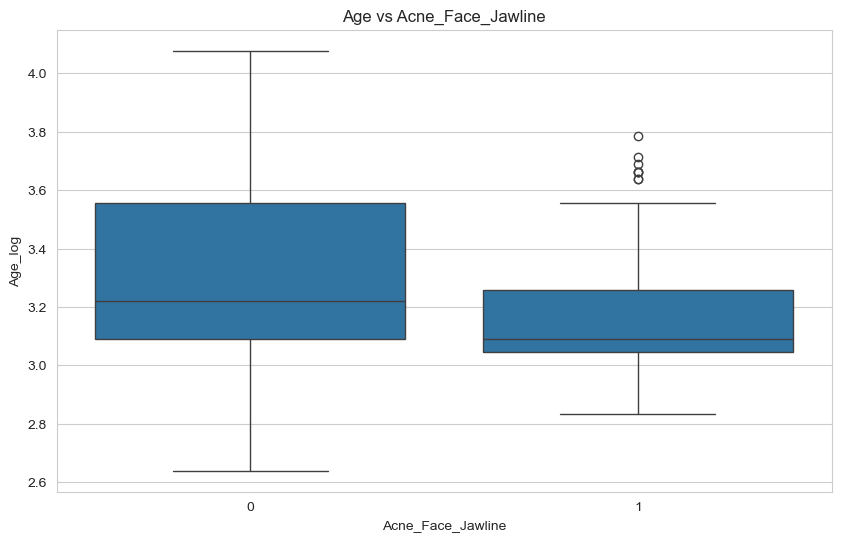

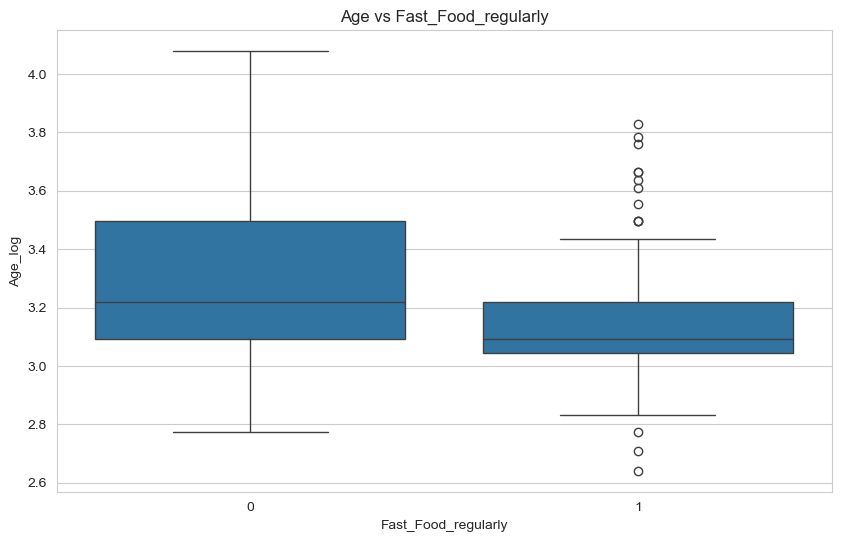

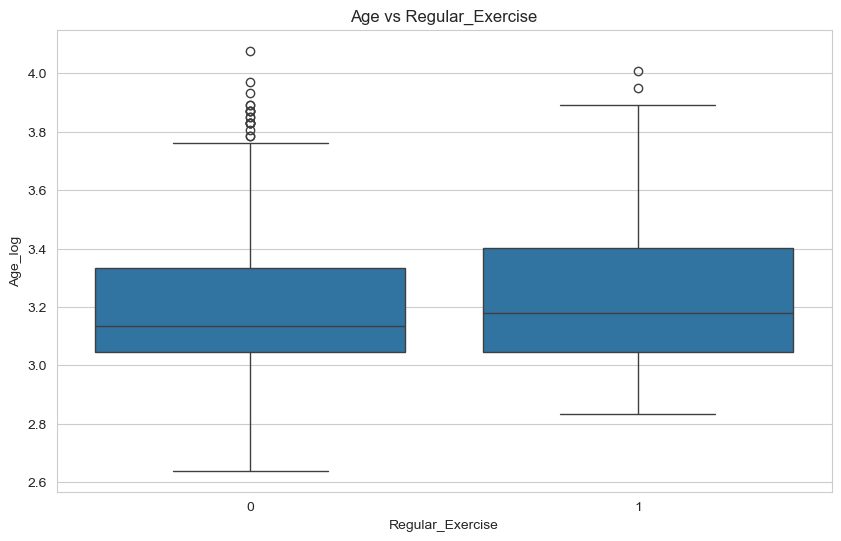

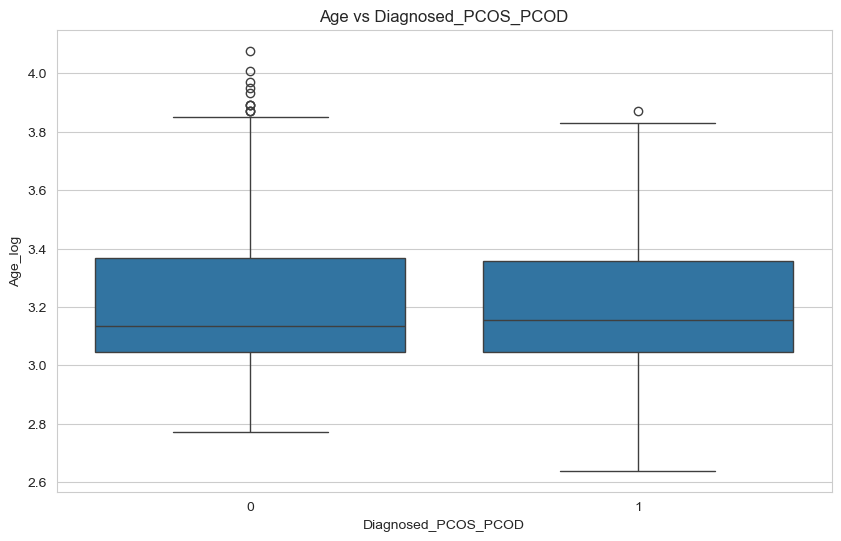

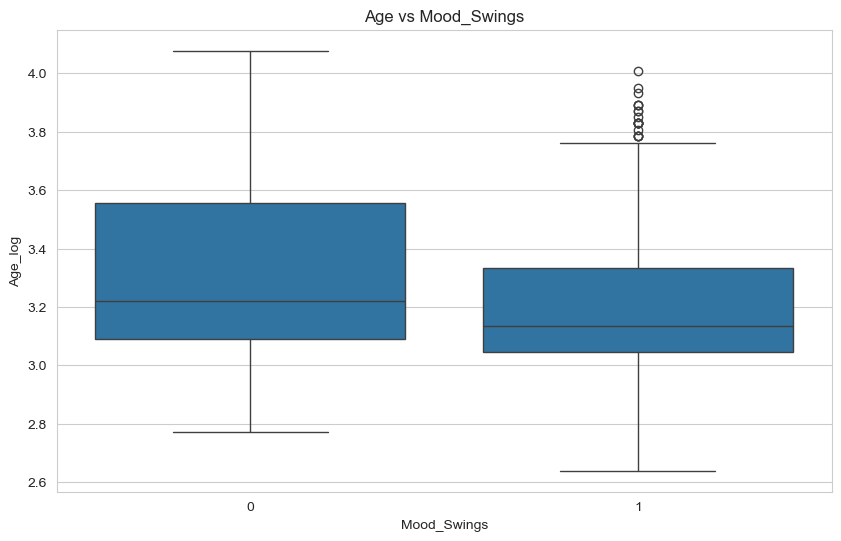

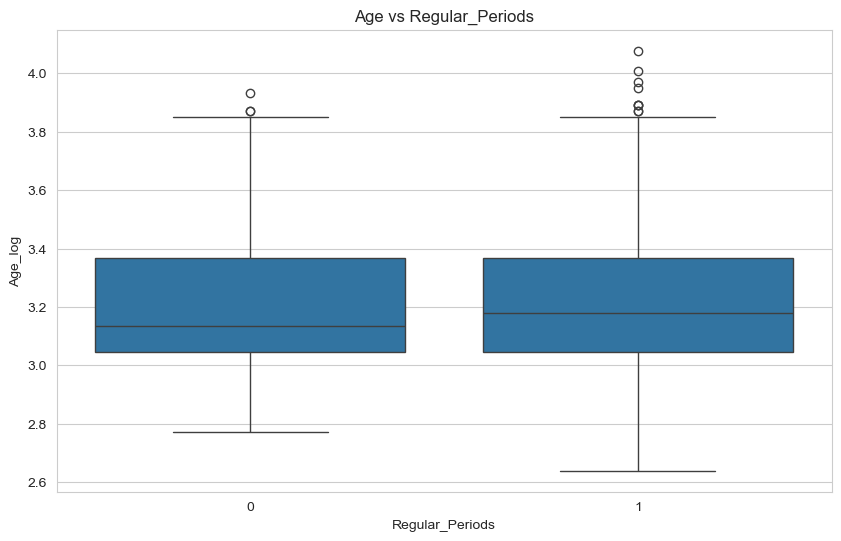

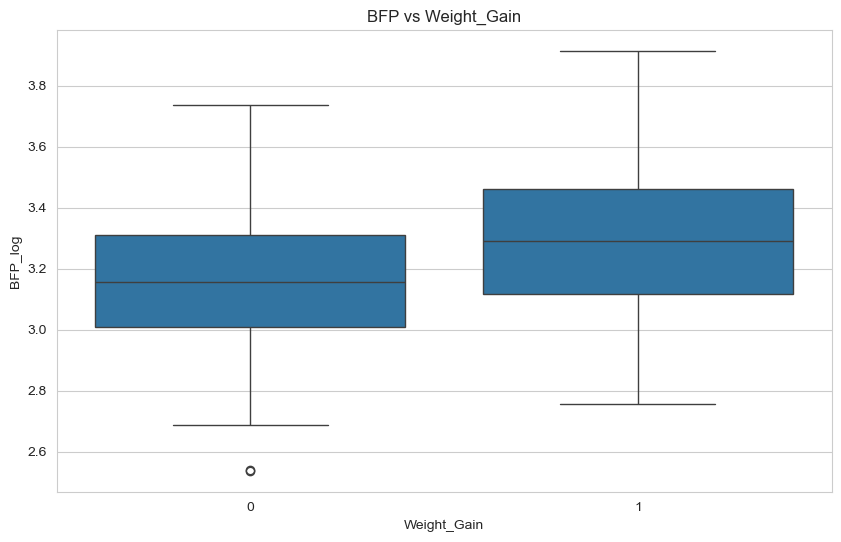

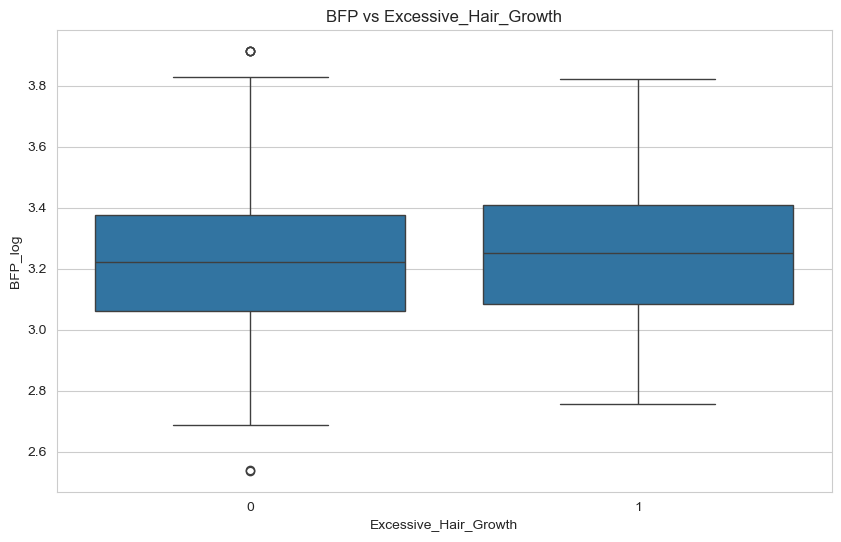

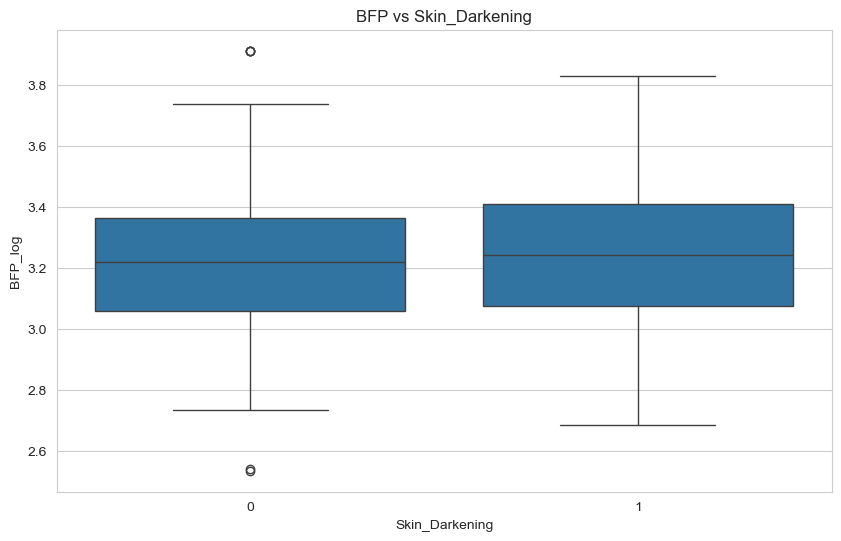

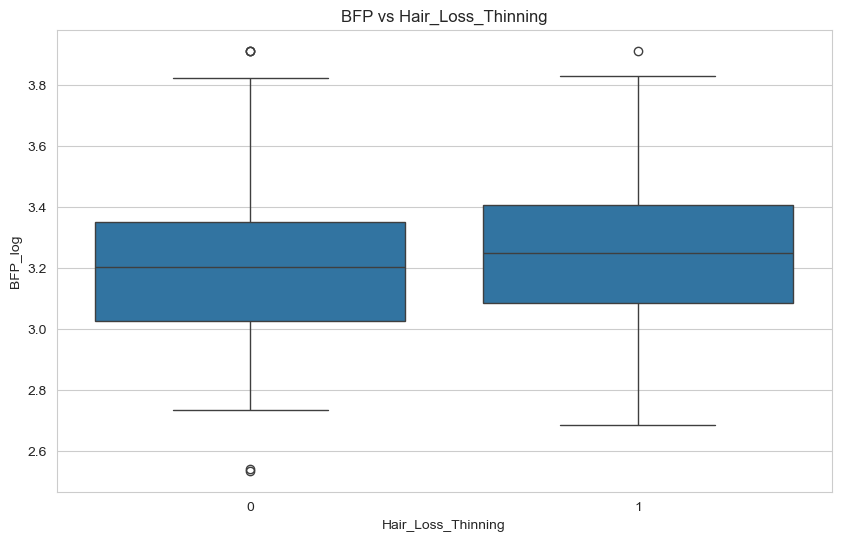

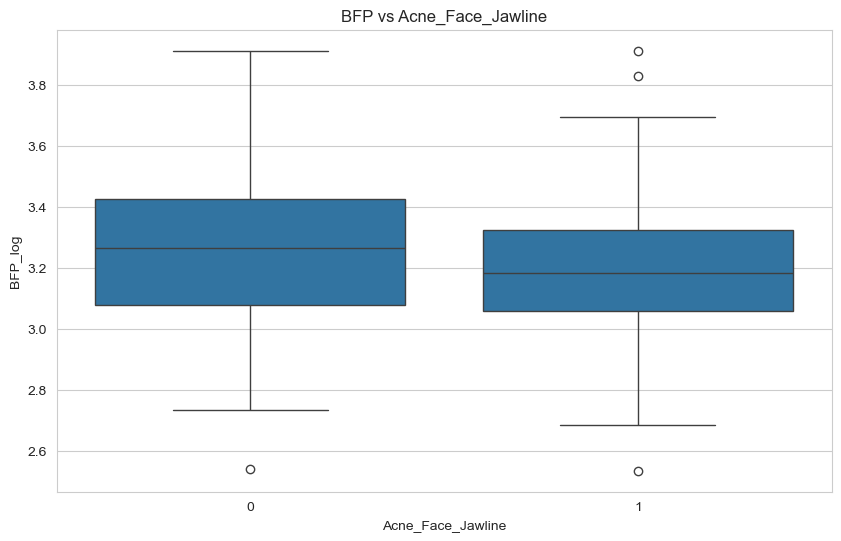

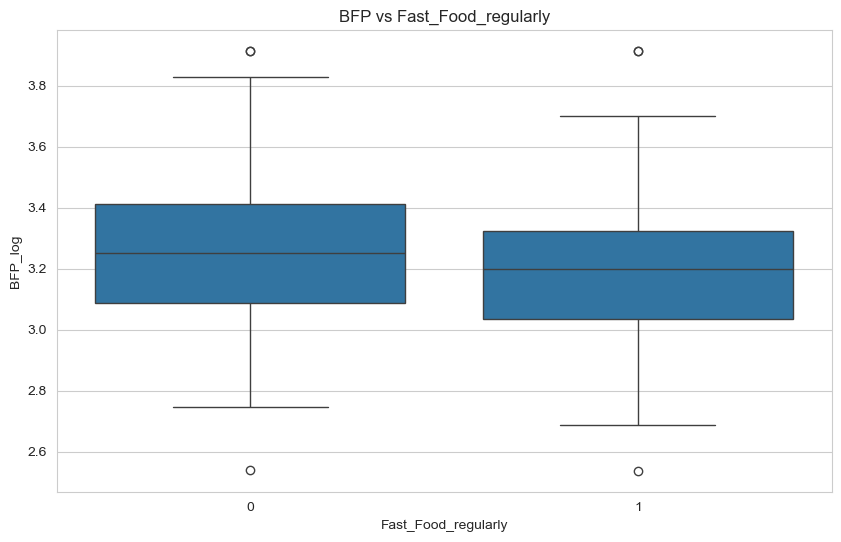

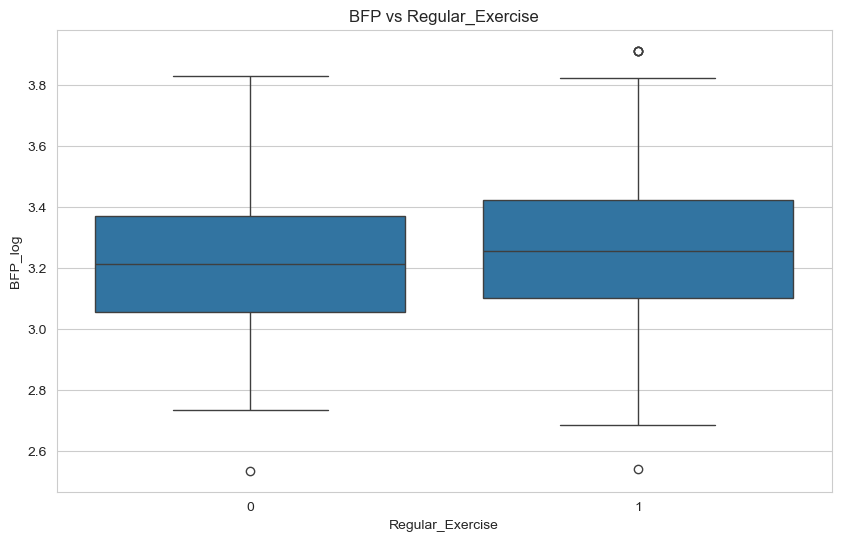

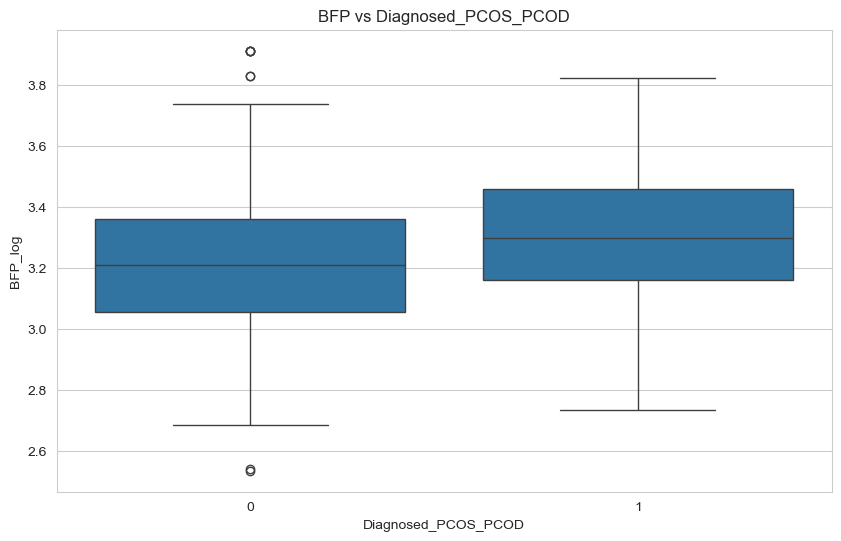

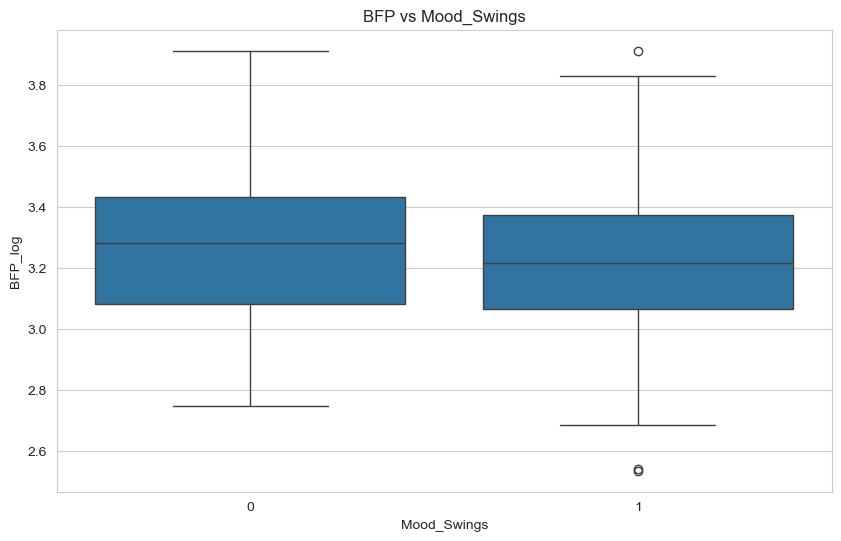

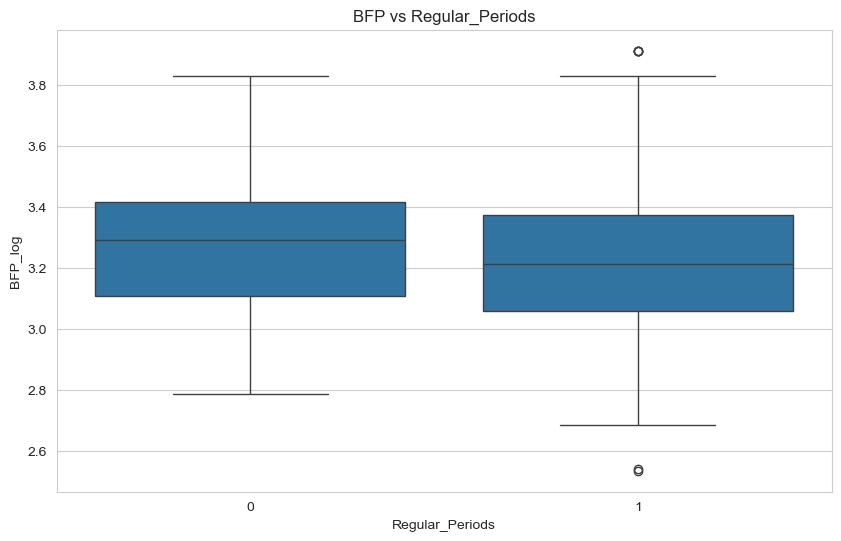

In [159]:
# 1. Plot Age vs Categorical Features
for cat_col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_col, y='Age_log', data=df_survey)
    plt.title(f'Age vs {cat_col}')
    plt.show()

# 2. Plot BFP vs Categorical Features
for cat_col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_col, y='BFP_log', data=df_survey)
    plt.title(f'BFP vs {cat_col}')
    plt.show()

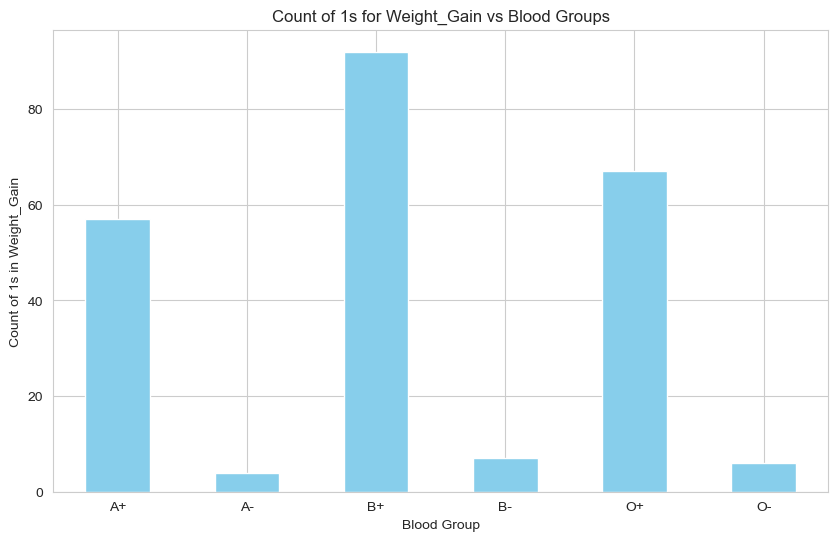

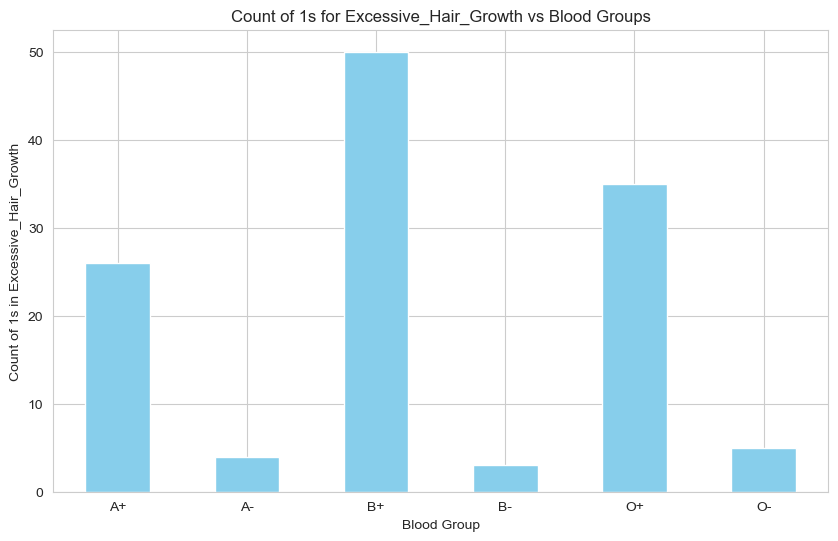

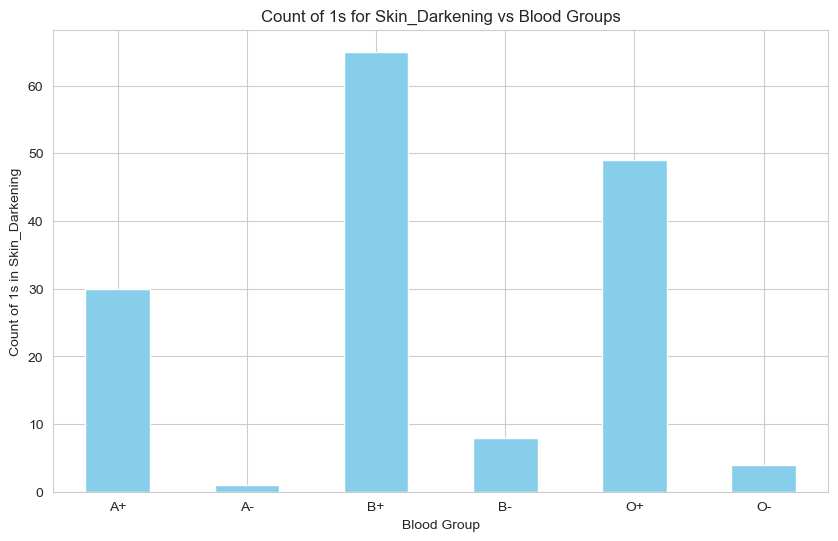

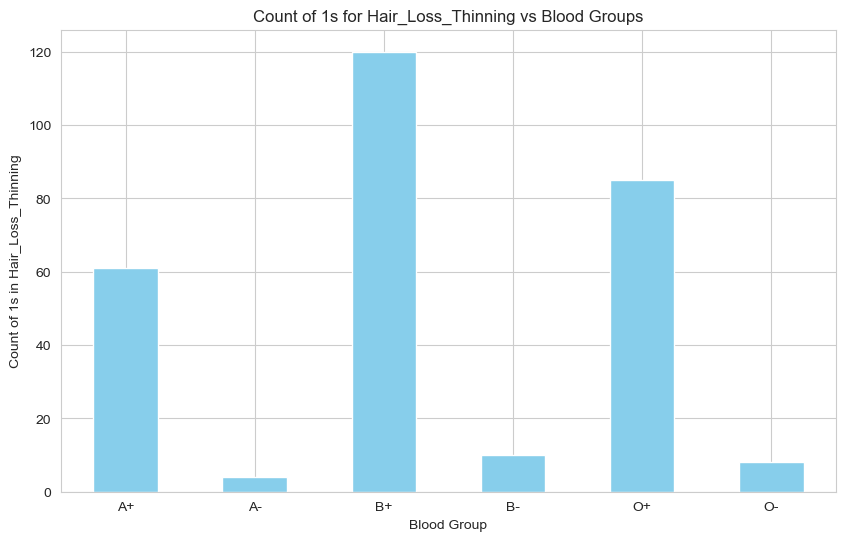

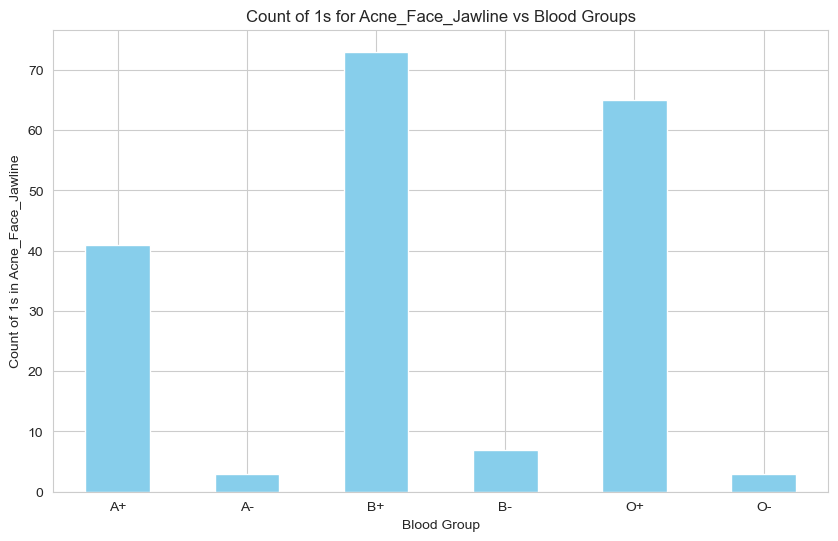

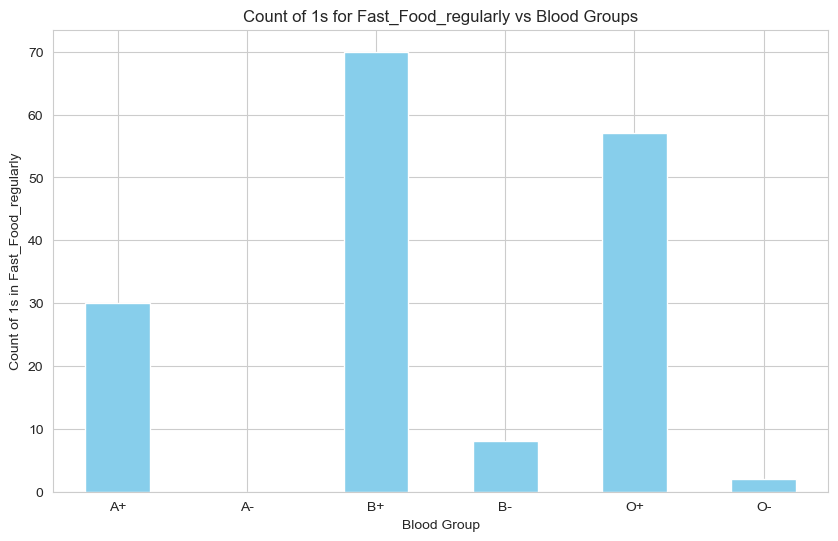

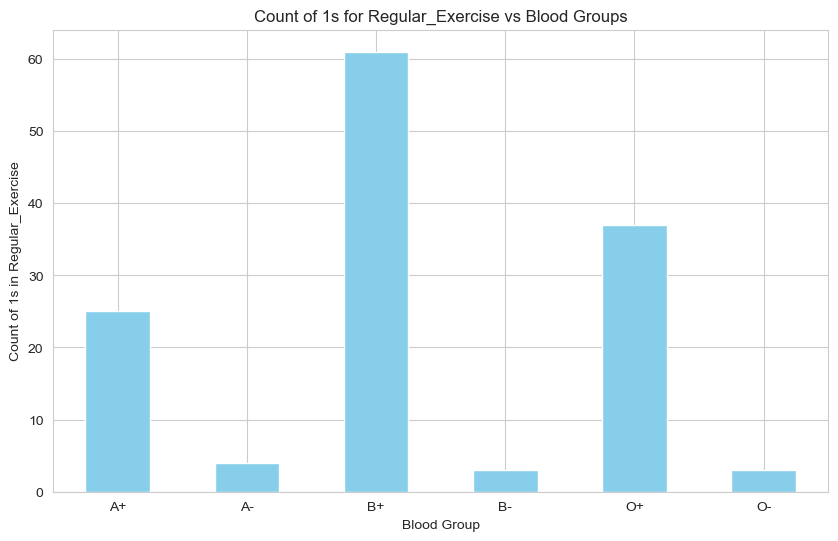

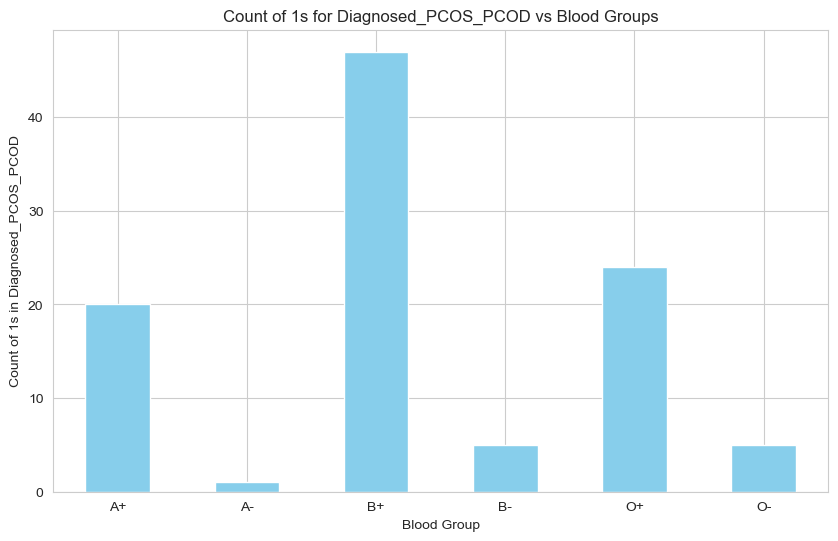

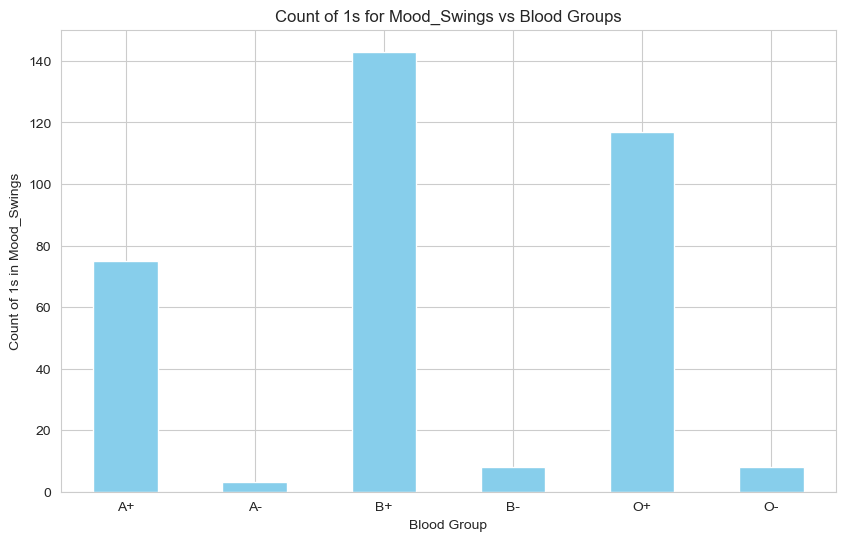

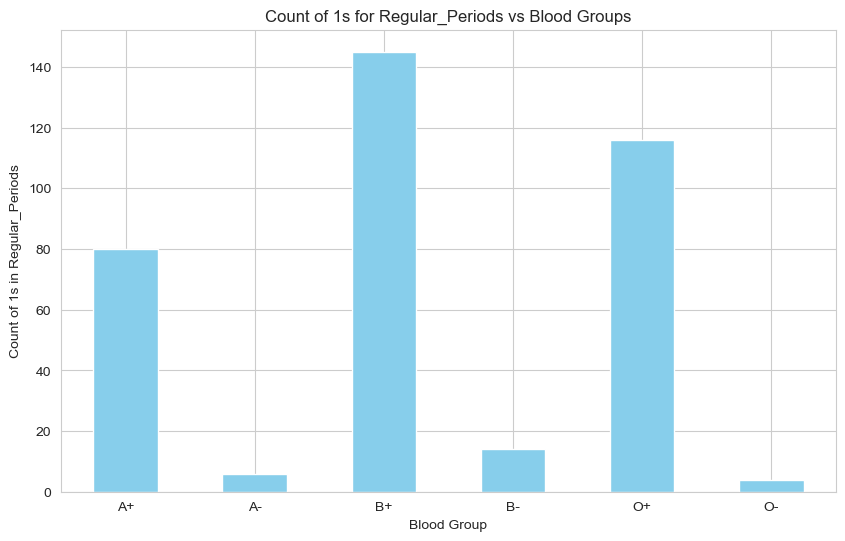

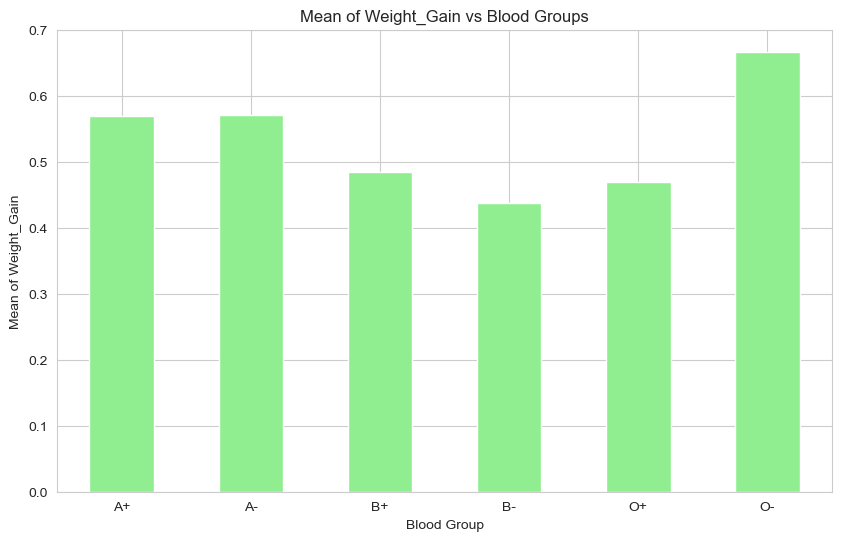

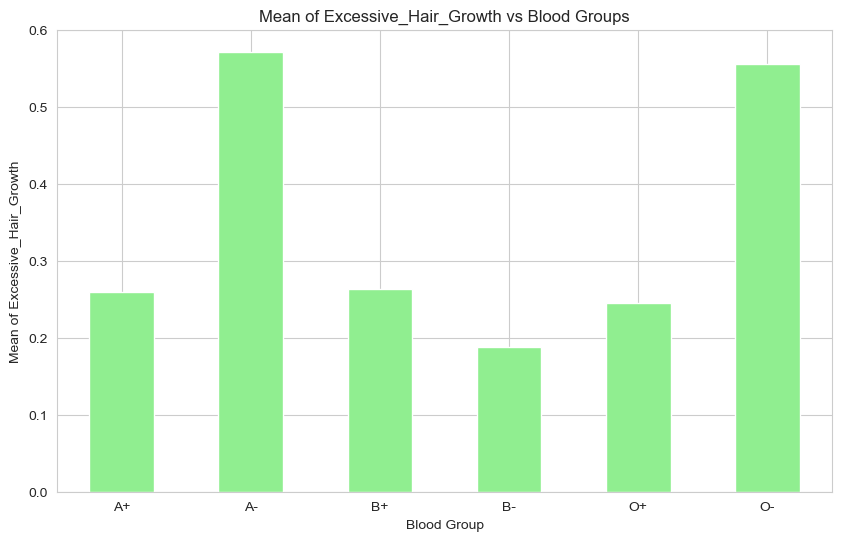

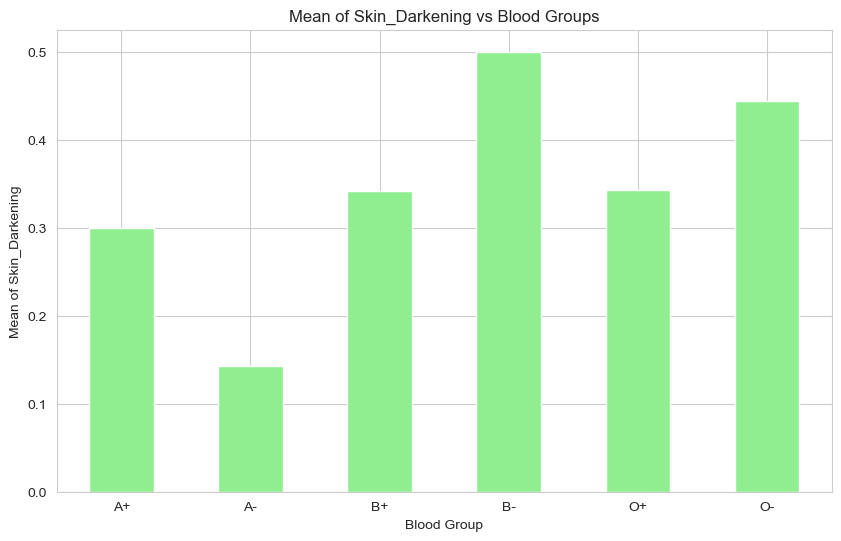

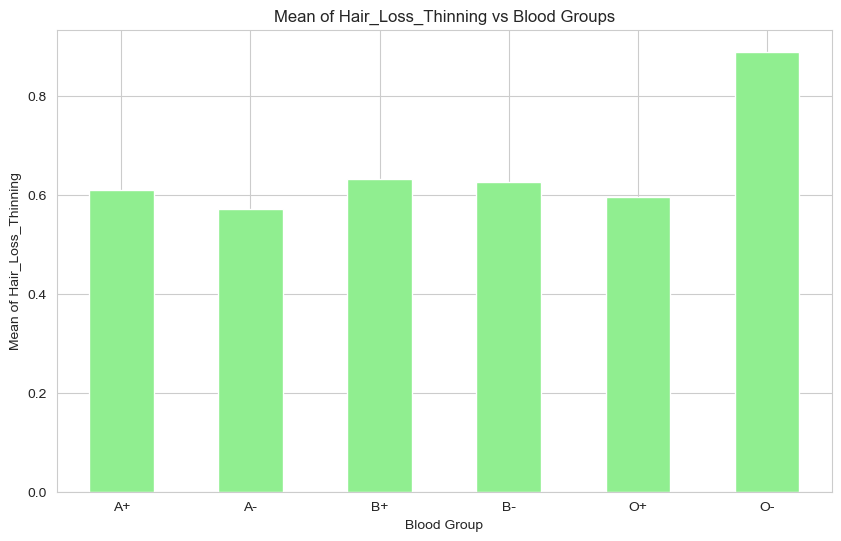

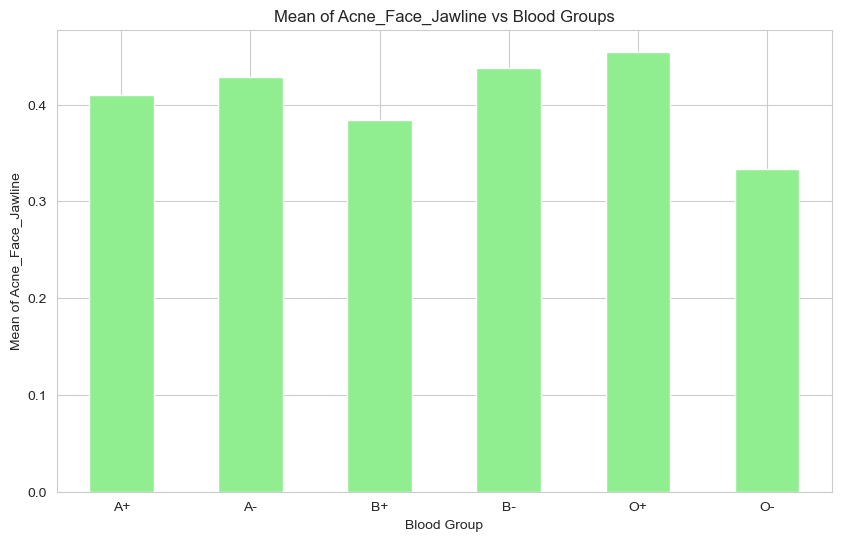

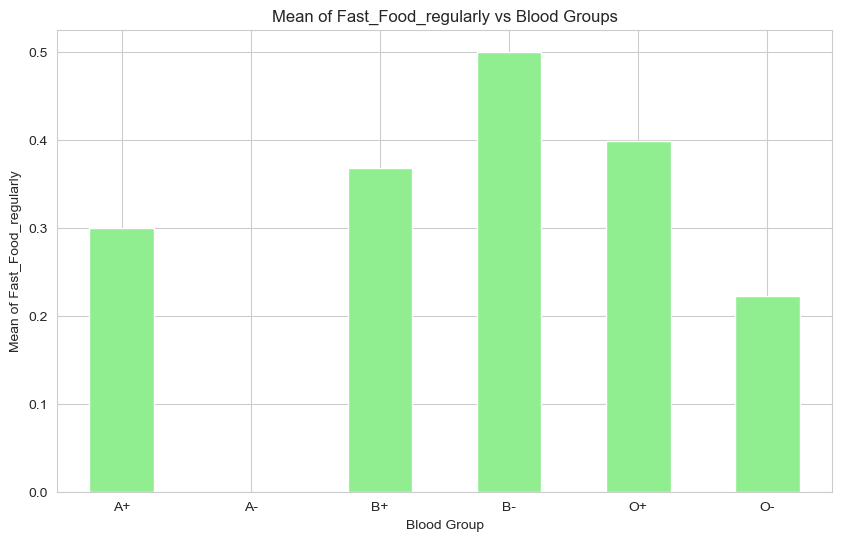

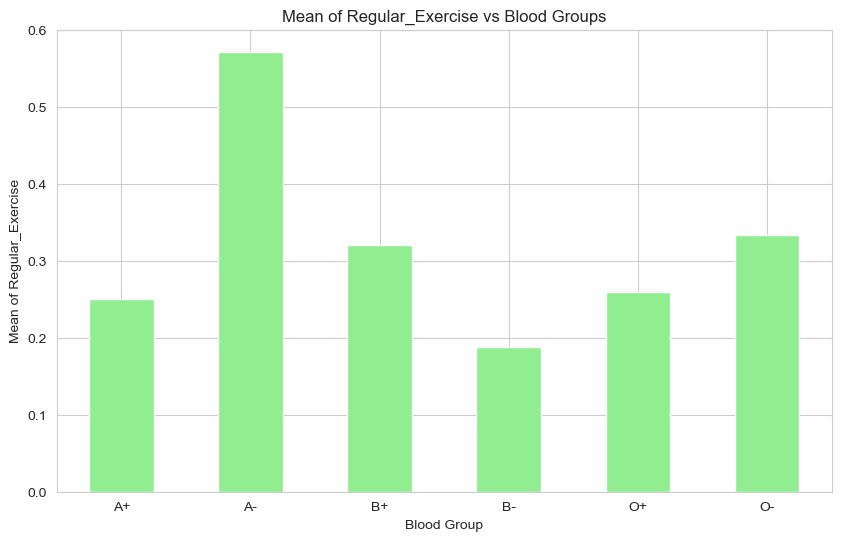

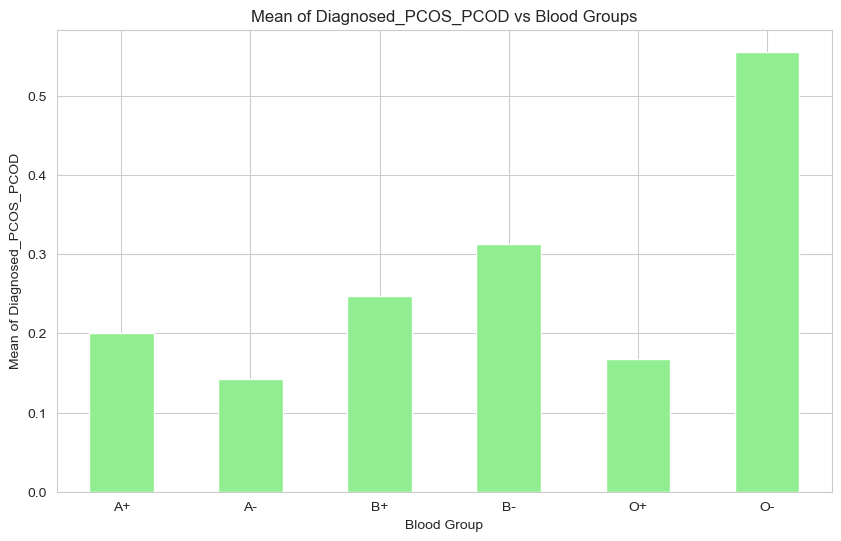

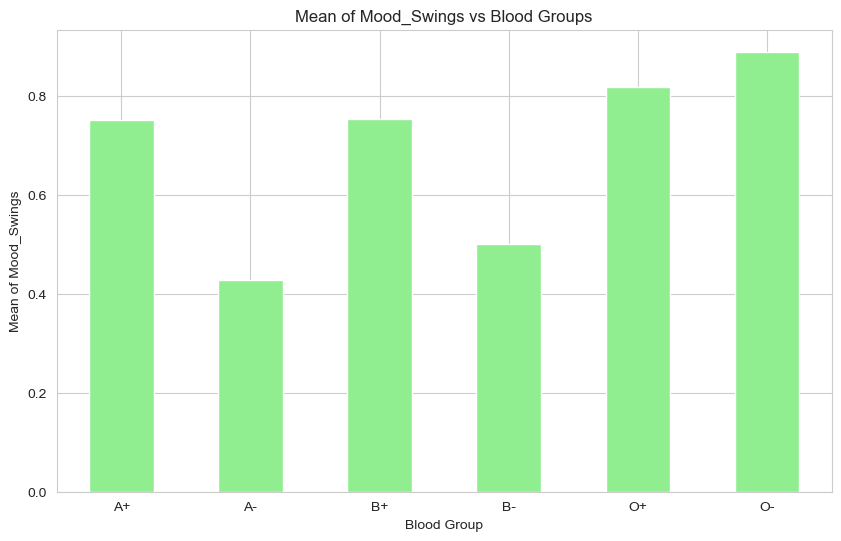

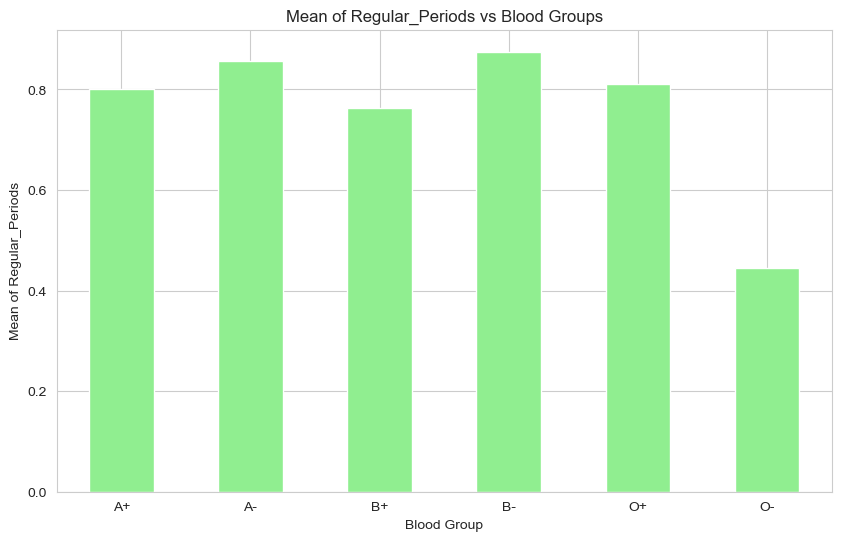

In [163]:
# Blood group mapping dictionary
blood_group_mapping = {
    11: 'A+', 
    12: 'A-', 
    13: 'B+', 
    14: 'B-', 
    15: 'O+', 
    16: 'O-', 
    17: 'AB+', 
    18: 'AB-'
}


# 1. Bar Plot (Count of 1s per Blood Group)
for binary_col in categorical_columns:
    plt.figure(figsize=(10, 6))
    # Count the number of 1s for each blood group category
    counts = df_survey.groupby('Blood_Group')[binary_col].sum()
    
    # Replace numeric codes with blood group labels
    counts.index = counts.index.map(blood_group_mapping)
    
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Count of 1s for {binary_col} vs Blood Groups')
    plt.xlabel('Blood Group')
    plt.ylabel(f'Count of 1s in {binary_col}')
    plt.xticks(rotation=0)
    plt.show()

# 2. Bar Plot (Mean of Binary Columns per Blood Group)
for binary_col in categorical_columns:
    plt.figure(figsize=(10, 6))
    # Calculate the mean for each blood group
    means = df_survey.groupby('Blood_Group')[binary_col].mean()
    
    # Replace numeric codes with blood group labels
    means.index = means.index.map(blood_group_mapping)
    
    means.plot(kind='bar', color='lightgreen')
    plt.title(f'Mean of {binary_col} vs Blood Groups')
    plt.xlabel('Blood Group')
    plt.ylabel(f'Mean of {binary_col}')
    plt.xticks(rotation=0)
    plt.show()


In [165]:
df_survey.describe()

,Age (in Years),Weight (in Kg),Height (in Cm / Feet),Blood_Group,Periods_Frequency,Weight_Gain,Excessive_Hair_Growth,Skin_Darkening,Hair_Loss_Thinning,Acne_Face_Jawline,...,Regular_Exercise,Diagnosed_PCOS_PCOD,Mood_Swings,Regular_Periods,Period_Duration_Days,Height_meters,Body_Mass_Index,Body_Fat_Percentage,BFP_log,Age_log
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,...,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,25.455914,59.286667,157.916473,13.262366,1.221505,0.501075,0.264516,0.337634,0.619355,0.412903,...,0.286022,0.219355,0.761290,0.784946,4.600000,1.579165,199.088116,25.964497,3.228636,3.236051
std,8.099775,11.137046,14.933218,1.499994,0.541758,0.500537,0.441550,0.473412,0.486068,0.492886,...,0.452386,0.414255,0.426754,0.411302,1.536622,0.149332,2624.768194,6.318620,0.235969,0.270499
min,13.000000,33.000000,4.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,13.387967,12.628153,2.535929,2.639057
25%,20.000000,51.000000,154.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,4.000000,1.540000,20.519134,21.551358,3.070439,3.044522
50%,22.000000,58.000000,160.000000,13.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,5.000000,1.600000,22.959184,25.217595,3.227542,3.135494
75%,28.000000,65.000000,164.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,5.000000,1.640000,25.969529,29.598095,3.387710,3.367296
max,58.000000,100.000000,186.000000,16.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,15.000000,1.860000,47500.000000,50.000000,3.912023,4.077537


In [ ]:
def detect_missing_values(df):
    num_df = df.select_dtypes(include=['number'])  # Select only numerical columns
    missing_count = num_df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage': missing_percentage
    })
    
    return missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)


In [167]:
df_infertility.shape

(541, 6)

In [169]:
df_infertility.head

<bound method NDFrame.head of      Sl. No  Patient File No.  PCOS (Y/N)    I   beta-HCG(mIU/mL)  \
0         1             10001           0                    1.99   
1         2             10002           0                   60.80   
2         3             10003           1                  494.08   
3         4             10004           0                    1.99   
4         5             10005           0                  801.45   
..      ...               ...         ...                     ...   
536     537             10537           0                    1.99   
537     538             10538           0                   80.13   
538     539             10539           0                    1.99   
539     540             10540           0                  292.92   
540     541             10541           1                    1.99   

     II    beta-HCG(mIU/mL) AMH(ng/mL)  
0                      1.99       2.07  
1                      1.99       1.53  
2                 

In [181]:
df_infertility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3     I   beta-HCG(mIU/mL)  541 non-null    float64
 4   II    beta-HCG(mIU/mL)  541 non-null    float64
 5   AMH(ng/mL)              540 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 25.5 KB


In [205]:
# Strip all extra spaces from column names
df_infertility.columns = df_infertility.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Verify the cleaned column names
print(df_infertility.columns)


Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'I beta-HCG(mIU/mL)',
       'II beta-HCG(mIU/mL)', 'AMH(ng/mL)'],
      dtype='object')


In [183]:
df_infertility.describe()

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
count,541.000000,541.000000,541.000000,541.000000,541.000000,540.000000
mean,271.000000,10271.000000,0.327172,664.549235,238.229518,5.624191
std,156.317519,156.317519,0.469615,3348.920576,1603.826221,5.881608
min,1.000000,10001.000000,0.000000,1.300000,0.110417,0.100000
25%,136.000000,10136.000000,0.000000,1.990000,1.990000,2.010000
50%,271.000000,10271.000000,0.000000,20.000000,1.990000,3.700000
75%,406.000000,10406.000000,1.000000,297.210000,97.630000,6.925000
max,541.000000,10541.000000,1.000000,32460.970000,25000.000000,66.000000


In [177]:

df_infertility['AMH(ng/mL)'].unique()

array(['2.07', '1.53', '6.63', '1.22', '2.26', '6.74', '3.05', '1.54',
       '1', '1.61', '4.47', '1.67', '7.94', '2.38', '0.88', '0.69',
       '3.78', '1.92', '2.85', '2.13', '4.13', '2.5', '1.89', '0.26',
       '3.84', '3.56', '1.56', '1.69', '2.34', '1.58', '2.36', '3.64',
       '2.78', '0.33', '2.35', '3.88', '3.55', '4.33', '3.66', '4.5',
       '3.2', '2.1', '6.55', '1.2', '2.33', '3.22', '2.333', '2.31',
       '4.2', '3.21', '2.14', '2.3', '4.6', '5.8', '5.2', '4.63', '1.01',
       '2.58', '0.35', '5.23', '3.68', '2.55', '4.91', '1.03', '6.56',
       '3.91', '5.42', '1.65', '2.06', '1.81', '3.81', '3.65', '8.98',
       '1.7', '3.18', '2.75', '0.86', '2.29', '2.19', '8.46', '4.59',
       '1.04', '4.27', '3.86', '1.42', '10.07', '0.98', '4.07', '3.9',
       '10', '16.9', '17', '21.9', '1.6', '3.3', '21', '12.7', '1.8',
       '3.6', '15', '5', '17.9', '19.8', '9.2', '2.4', '5.14', '0.3',
       '11.48', '19.3', '8.8', '19', '4.3', '1.4', '12.6', '4.8', '17.1',
       '11

In [179]:
# Convert 'AMH(ng/mL)' column to numeric, coercing errors (non-numeric values will be converted to NaN)
df_infertility['AMH(ng/mL)'] = pd.to_numeric(df_infertility['AMH(ng/mL)'], errors='coerce')


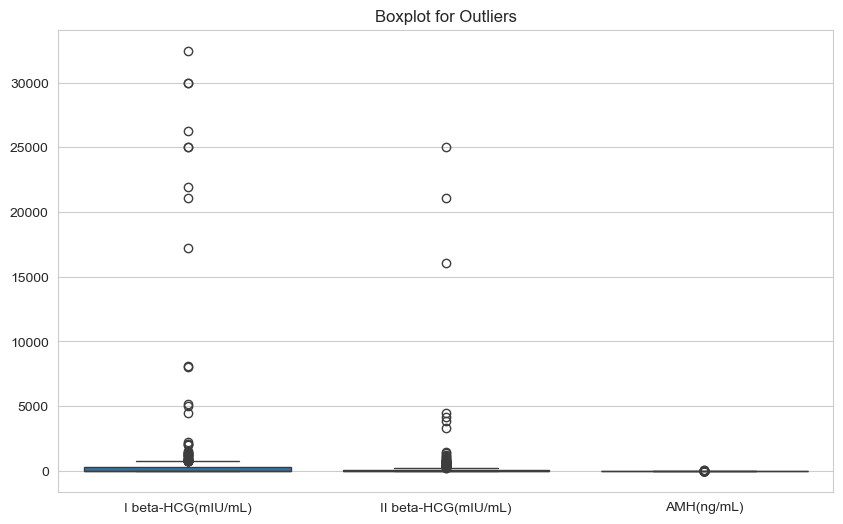

Column: I beta-HCG(mIU/mL)
Lower Bound: -442.0849999999999
Upper Bound: 742.1149999999999
Outliers:
     Sl. No  Patient File No.  PCOS (Y/N)  I beta-HCG(mIU/mL)  \
4         5             10005           0              801.45   
12       13             10013           1             1214.23   
16       17             10017           0             8104.21   
21       22             10022           0              749.98   
25       26             10026           0             4490.18   
29       30             10030           1              768.03   
34       35             10035           0             1277.49   
35       36             10036           0             1455.00   
44       45             10045           1             1305.35   
47       48             10048           0             1500.00   
63       64             10064           0              757.17   
76       77             10077           1              756.61   
95       96             10096           1             1

In [209]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return lower_bound, upper_bound, outliers

# Detect outliers and bounds for each relevant column
columns_to_check = ['I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)', 'AMH(ng/mL)']
outliers_info = {}

for column in columns_to_check:
    lower, upper, outliers = detect_outliers(df_infertility_clean, column)
    outliers_info[column] = {
        'lower_bound': lower,
        'upper_bound': upper,
        'outliers': outliers
    }

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_infertility_clean[columns_to_check])
plt.title('Boxplot for Outliers')
plt.xticks([0, 1, 2], ['I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)', 'AMH(ng/mL)'])
plt.show()

# Print outliers' bounds and values
for column, info in outliers_info.items():
    print(f"Column: {column}")
    print(f"Lower Bound: {info['lower_bound']}")
    print(f"Upper Bound: {info['upper_bound']}")
    print(f"Outliers:\n{info['outliers']}\n")

In [ ]:
data.describe() 

In [ ]:
#Categorical Features
cat_features = data.select_dtypes(include=['object','bool']).columns.tolist()
cat_features

In [ ]:
data2=data.copy()

In [ ]:
data2.isnull().sum()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Créer un objet LabelEncoder
label_encoder = LabelEncoder()

data2['AMH(ng/mL)_encoded'] = label_encoder.fit_transform(data2['AMH(ng/mL)'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme de AMH
plt.figure(figsize=(8, 6))
sns.histplot(data2['AMH(ng/mL)_encoded'], kde=True, bins=20, color='blue')
plt.title('Distribution de AMH (ng/mL)')
plt.xlabel('AMH (ng/mL)')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='PCOS (Y/N)', y='AMH(ng/mL)_encoded', data=data2, palette='Set2')
plt.title('AMH (ng/mL) par statut PCOS')
plt.xlabel('PCOS (0 = Non, 1 = Oui)')
plt.ylabel('AMH (ng/mL)')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=data2['AMH(ng/mL)'], color='purple')
plt.title('Boxplot de AMH (ng/mL)')
plt.ylabel('AMH (ng/mL)')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppression des espaces multiples dans les noms des colonnes
data2.columns = data2.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Vérification des noms des colonnes après nettoyage
print("Colonnes disponibles après nettoyage :", data2.columns.tolist())

# Visualisation : Distribution des niveaux de I beta-HCG
plt.figure(figsize=(8, 6))
sns.histplot(data=data2, x='I beta-HCG(mIU/mL)', kde=True, color='skyblue')
plt.title('Distribution de I beta-HCG (mIU/mL)')
plt.xlabel('I beta-HCG (mIU/mL)')
plt.show()

# Visualisation de la relation entre I et II beta-HCG
plt.figure(figsize=(8, 6))
sns.scatterplot(x='I beta-HCG(mIU/mL)', y='II beta-HCG(mIU/mL)',
                data=data2, hue='PCOS (Y/N)', palette='Set1')
plt.title('Relation entre I beta-HCG et II beta-HCG')
plt.xlabel('I beta-HCG (mIU/mL)')
plt.ylabel('II beta-HCG (mIU/mL)')
plt.legend(title='PCOS')
plt.show()
